## Processing data

In [1]:
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import powerlaw
from bokeh.io import output_file, save
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure
from bokeh.palettes import d3

from IPython.display import FileLink

In [2]:
# Increase width to be able to better read the reviews when displaying dataframe
pd.options.display.max_colwidth = 100

In [3]:
# Constant definitions
REVIEW_FILE = "Grocery_and_Gourmet_Food.json"
REVIEW_PICKLE = "reviews"
META_FILE = "meta_Grocery_and_Gourmet_Food.json"
META_PICKLE = "meta"
DATA_LOCATION = "data/"
PICKLE_LOCATION = "processed-data/"
PLOTS_LOCATION = "milestone-2-plots/"

In [4]:
def load_pickle(pickle_name):
    with open(PICKLE_LOCATION+pickle_name, 'rb') as file:
        print(f'loading pickle for {pickle_name}...')
        return pickle.load(file)

In [5]:
def save_pickle(result, pickle_name):
    with open(PICKLE_LOCATION+pickle_name, 'wb') as file:
        print(f'saving pickle for {pickle_name}...')
        pickle.dump(result, file)

In [6]:
def read_file(file):
    if file == REVIEW_FILE:
        pickle_name = REVIEW_PICKLE
    elif file == META_FILE:
        pickle_name = META_PICKLE
    else:
        pickle_name = file
    
    try:
        return load_pickle(pickle_name)
    except (FileNotFoundError, EOFError) as e:
        file_df = pd.read_json(DATA_LOCATION+file, lines=True)
        save_pickle(file_df, pickle_name)
        return file_df

First we load the data and see what it looks like, in order to sanitize it.

We have 2 data files, one containing Amazon 'Grocery and Gourmet Food' reviews, the other one containing meta information about the products.

In [7]:
reviews = read_file(REVIEW_FILE)
meta = read_file(META_FILE)
print("Meta dataset:")
display(meta.head())
print("\nReviews dataset:")
reviews

loading pickle for reviews...
loading pickle for meta...
Meta dataset:


,category,description,title,brand,rank,also_view,main_cat,price,asin,also_buy,image,date,feature,details,similar_item,tech1,fit
0,"[Grocery & Gourmet Food, Dairy, Cheese & Eggs, Cheese, Gouda]","[BEEMSTER GOUDA CHEESE AGED 18/24 MONTHS, Statements regarding dietary supplements have not been...",Beemster Gouda - Aged 18/24 Months - App. 1.5 Lbs,Ariola Imports,"165,181inGroceryGourmetFood(","[B0000D9MYM, B0000D9MYL, B00ADHIGBA, B00H9OX598, B001LM42GY, B001LM5TDY]",Grocery,$41.91,0681727810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"[Grocery & Gourmet Food, Cooking & Baking, Sugar Substitutes, Xylitol]","[Shipped from UK, please allow 10 to 21 business days for arrival. ex lib pub by Applied Science...",Trim Healthy Mama Xylitol,NaN,"315,867inGroceryGourmetFood(",NaN,Grocery,NaN,0853347867,"[B01898YHXK, B01BCM6LAC, B00Q4OL47O, B00Q4OL5QE, 0804189986, B00Q4OL2F8, 1101902663, B019PDEUU8,...","[https://images-na.ssl-images-amazon.com/images/I/5135fT93xtL._SS40_.jpg, https://images-na.ssl-...",NaN,NaN,NaN,NaN,NaN,NaN
2,"[Grocery & Gourmet Food, Cooking & Baking, Frosting, Icing & Decorations, Cake & Cupcake Toppers...",[Jazz up your cakes with a sparkling monogram from our Sparkling collection! These single letter...,Letter C - Swarovski Crystal Monogram Wedding Cake Topper Letter,Unik Occasions,">#669,941 in Kitchen & Dining (See Top 100 in Kitchen & Dining)>#9,899 in Kitchen & Dining > Bak...",[B07DXN65TF],Amazon Home,$29.95,1888861118,NaN,NaN,"September 21, 2010",NaN,NaN,NaN,NaN,NaN
3,"[Grocery & Gourmet Food, Cooking & Baking, Frosting, Icing & Decorations, Cake & Cupcake Toppers...","[Large Letter - Height 4.75""]",Letter H - Swarovski Crystal Monogram Wedding Cake Topper Letter,Other,">#832,581 in Kitchen & Dining (See Top 100 in Kitchen & Dining)>#12,883 in Kitchen & Dining > Ba...",NaN,Amazon Home,$11.45,1888861517,NaN,NaN,"September 11, 2011","[Large Letter - Height 4.75""]",NaN,NaN,NaN,NaN
4,"[Grocery & Gourmet Food, Cooking & Baking, Frosting, Icing & Decorations, Cake & Cupcake Toppers...","[4.75""]",Letter S - Swarovski Crystal Monogram Wedding Cake Topper Letter,Unik Occasions,">#590,999 in Kitchen & Dining (See Top 100 in Kitchen & Dining)>#8,585 in Kitchen & Dining > Bak...",NaN,Amazon Home,$15.00,1888861614,NaN,NaN,"September 11, 2011","[4.75"" height]",NaN,NaN,NaN,NaN



Reviews dataset:


,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,image,style
0,5,True,"06 4, 2013",ALP49FBWT4I7V,1888861614,Lori,Very pleased with my purchase. Looks exactly like the picture and will look great on my cake. It...,Love it,1370304000,NaN,NaN,NaN
1,4,True,"05 23, 2014",A1KPIZOCLB9FZ8,1888861614,BK Shopper,Very nicely crafted but too small. Am going to have to add some flowers or something to compensa...,Nice but small,1400803200,NaN,NaN,NaN
2,4,True,"05 9, 2014",A2W0FA06IYAYQE,1888861614,daninethequeen,still very pretty and well made...i am super picky so don't listen to me...*whispers* but it doe...,"the ""s"" looks like a 5, kina",1399593600,NaN,NaN,NaN
3,5,True,"04 20, 2014",A2PTZTCH2QUYBC,1888861614,Tammara,"I got this for our wedding cake, and it was everything even more on in person, I would recommend...",Would recommend this to a friend!,1397952000,NaN,NaN,NaN
4,4,True,"04 16, 2014",A2VNHGJ59N4Z90,1888861614,LaQuinta Alexander,It was just what I want to put at the top of my wedding cake. I love it & it's true to the picture.,Topper,1397606400,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
5074155,5,True,"10 4, 2018",AGOPF2VTEOP57,B01HJHSVG6,Bob,"Love this product, very fresh, complete full flavor, will buy again",Exceclent product,1538611200,NaN,NaN,{'Size:': ' 2.29 oz'}
5074156,3,True,"10 3, 2018",A5X5TI4JCH9CN,B01HJHSVG6,Jacqueline Schafer,Good taste but small quantity for the expensive price. Organic vanilla is usually not so expensi...,Good taste but small quantity for the price used 3/4 of this for 1 recipe,1538524800,NaN,NaN,{'Size:': ' 2.29 oz'}
5074157,4,True,"10 2, 2018",A1WMQQLC3TVAFI,B01HJHSVG6,Motionjunkie,"Unlike some of the bad reviews regarding aroma, when I opened the glass jar, I got a good whiff ...",See Comments below,1538438400,NaN,NaN,{'Size:': ' 2.29 oz'}
5074158,5,True,"09 30, 2018",ALVP6JZRTEDY6,B01HJHSVG6,Marissa,I absolutely love this vanilla bean paste. I had been using vanilla extract for my dessert and b...,Love!!,1538265600,NaN,NaN,{'Size:': ' 2.29 oz'}


We have 5'064'160 reviews and these reviews have 12 attributes. Here is [an example](https://www.amazon.com/gp/customer-reviews/R3OL49W8SWC4EW/ref=cm_cr_arp_d_rvw_ttl?ie=UTF8&ASIN=B0000D916Y) of an Amazon review to illustrate, coming from [this product](https://www.amazon.com/Davids-Cookies-Christmas-Corporate-Certified/dp/B0000D916Y/ref=cm_cr_arp_d_product_top?ie=UTF8).

<img src="misc/amazon-review-example.png">

First let's try to find this review.

In [8]:
reviews_example = reviews[reviews["summary"] == "Not your average tin of cookies!"]
reviews_example

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,image,style
7935,5,False,"01 22, 2018",A129TBMOQD79CZ,B0000D916Y,Shawna J. Pierce,Someone sent us a tin of Davids Cookies over the holidays and they were DELICIOUS. These are now...,Not your average tin of cookies!,1516579200,NaN,NaN,"{'Size:': ' 1 lbs (12 -1.5oz cookies)', 'Flavor:': ' Chocolate Chunk'}"
9256,5,False,"01 22, 2018",A129TBMOQD79CZ,B0000D9169,Shawna J. Pierce,Someone sent us a tin of Davids Cookies over the holidays and they were DELICIOUS. These are now...,Not your average tin of cookies!,1516579200,NaN,NaN,NaN


Weird, these two reviews look like they are almost the same, but we'll get back to it later. Let's first understand the columns. Using this review: (and image to help comparing)

<img src="misc/amazon-review-example.png">

In [9]:
reviews_example[reviews_example["style"].notnull()]

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,image,style
7935,5,False,"01 22, 2018",A129TBMOQD79CZ,B0000D916Y,Shawna J. Pierce,Someone sent us a tin of Davids Cookies over the holidays and they were DELICIOUS. These are now...,Not your average tin of cookies!,1516579200,NaN,NaN,"{'Size:': ' 1 lbs (12 -1.5oz cookies)', 'Flavor:': ' Chocolate Chunk'}"


`overall`: the number of stars\
`verified`: tells us if the purchase has been verified, not the case here\
`reviewTime`: Time of the review (day)\
`reviewerID`: Id of the reviewer\
`asin`: Id of the reviewed product (here the cookies)\
`reviewerName`: The name of the reviewer\
`reviewText`: The content of the review\
`summary`: The small sentence to summarize the review (the bold text on the image)\
`unixReviewTime`: Time of the review in unix time\
`vote`: The number of "Helpful" a review has received, here it has received 0. So the value is NaN, they are in essence upvotes.\
`image`: You can link an image in your review on Amazon, here there is none\
`style`: The greyish link below the date, right below the date. It is in fact a link to buy this product: 12 cookies and chocolate chunk flavor

Here you can see an example of a verified review, with 6 upvotes:

<img src="misc/amazon-review-example-upvote.png">

Now let's look at bit closer at why we have two different reviews that look like they are the same.

In [10]:
# Show values that differ in the two reviews
reviews_example.loc[:, reviews_example.values[0] != reviews_example.values[1]]

,asin,vote,image,style
7935,B0000D916Y,NaN,NaN,"{'Size:': ' 1 lbs (12 -1.5oz cookies)', 'Flavor:': ' Chocolate Chunk'}"
9256,B0000D9169,NaN,NaN,NaN


So one of them has `style` while the other one doesn't and they are apparently not about the same product. This sounds weird, why would a person post the exact same comment for two different products?

Let's take a closer look at these two products

In [11]:
asins_example = reviews_example['asin'].values
product1 = meta[meta["asin"] == asins_example[0]]
product1

,category,description,title,brand,rank,also_view,main_cat,price,asin,also_buy,image,date,feature,details,similar_item,tech1,fit
402,"[Grocery & Gourmet Food, Snack Foods, Cookies, Chocolate Chip]","[, For those in search of a delicious, fresh, and certified kosher gift for family, friends, or ...","David's Cookies - 24 Fresh Baked M&M Candy Cookie Gourmet Gift Basket - Christmas, Holiday & Cor...",David's Cookies,"299,472inGroceryGourmetFood(","[B0000DA0XJ, B000PQQQSO, B000BB4SUG, B01NCEV877, B07KWG1PG2, B01E4KN8DM, B01N8OP47H, B00F4DF9JU,...",Grocery,NaN,B0000D916Y,"[B000BB4SUG, B01NCEV877, B000PQQQSO, B01E4KN8DM, B0000DA0XJ, B07KWG1PG2, B000PQQR4W, B01N8OP47H,...","[https://images-na.ssl-images-amazon.com/images/I/51X3C40yx%2BL._SS40_.jpg, https://images-na.ss...",NaN,NaN,"\n\n\n\n\n\n <div class=""disclaim"">Flavor: <strong>M&M</strong>&nbsp;|&nbsp;Size: <strong>2 l...",NaN,NaN,NaN
4099,"[Grocery & Gourmet Food, Snack Foods, Cookies, Chocolate Chip]","[, For those in search of a delicious, fresh, and certified kosher gift for family, friends, or ...","David's Cookies - 24 Fresh Baked M&M Candy Cookie Gourmet Gift Basket - Christmas, Holiday & Cor...",David's Cookies,"299,472inGroceryGourmetFood(","[B0000DA0XJ, B000PQQQSO, B000BB4SUG, B01NCEV877, B07KWG1PG2, B01E4KN8DM, B01N8OP47H, B00F4DF9JU,...",Grocery,NaN,B0000D916Y,"[B000BB4SUG, B01NCEV877, B000PQQQSO, B01E4KN8DM, B0000DA0XJ, B07KWG1PG2, B000PQQR4W, B01N8OP47H,...","[https://images-na.ssl-images-amazon.com/images/I/51X3C40yx%2BL._SS40_.jpg, https://images-na.ss...",NaN,NaN,"\n\n\n\n\n\n <div class=""disclaim"">Flavor: <strong>M&M</strong>&nbsp;|&nbsp;Size: <strong>2 l...",NaN,NaN,NaN


Two rows again, how weird! Let's look at how they differ:

In [12]:
product1.loc[:, product1.values[0] != product1.values[1]]

,price,date,feature,similar_item,tech1,fit
402,NaN,NaN,NaN,NaN,NaN,NaN
4099,NaN,NaN,NaN,NaN,NaN,NaN


This time they are exactly the same, that's interesting to note. We could safely remove one of them.

Let's look at the second product:

In [13]:
product2 = meta[meta["asin"] == asins_example[1]]
product2

,category,description,title,brand,rank,also_view,main_cat,price,asin,also_buy,image,date,feature,details,similar_item,tech1,fit
435,"[Grocery & Gourmet Food, Snack Foods, Cookies, Chocolate Chip]",NaN,"David's Cookies - 24 Fresh Baked Assorted Cookies Gourmet Gift Basket - Christmas, Holiday & Cor...",David's Cookies,"29,374inGroceryGourmetFood(","[B0000DA0XJ, B000PQQQSO, B000BB4SUG, B01NCEV877, B07KWG1PG2, B01E4KN8DM, B01N8OP47H, B00F4DF9JU,...",Grocery,$38.95,B0000D9169,"[B000BB4SUG, B01NCEV877, B000PQQQSO, B01E4KN8DM, B0000DA0XJ, B07KWG1PG2, B07KWFX2M3, B01N8OP47H,...","[https://images-na.ssl-images-amazon.com/images/I/51Qy2CQ-R1L._SS40_.jpg, https://images-na.ssl-...",NaN,NaN,"\n\n\n\n\n\n <div class=""disclaim"">Flavor: <strong>Assorted Flavors</strong>&nbsp;|&nbsp;Size...",NaN,NaN,NaN
4132,"[Grocery & Gourmet Food, Snack Foods, Cookies, Chocolate Chip]",NaN,"David's Cookies - 24 Fresh Baked Assorted Cookies Gourmet Gift Basket - Christmas, Holiday & Cor...",David's Cookies,"29,374inGroceryGourmetFood(","[B0000DA0XJ, B000PQQQSO, B000BB4SUG, B01NCEV877, B07KWG1PG2, B01E4KN8DM, B01N8OP47H, B00F4DF9JU,...",Grocery,$38.95,B0000D9169,"[B000BB4SUG, B01NCEV877, B000PQQQSO, B01E4KN8DM, B0000DA0XJ, B07KWG1PG2, B07KWFX2M3, B01N8OP47H,...","[https://images-na.ssl-images-amazon.com/images/I/51Qy2CQ-R1L._SS40_.jpg, https://images-na.ssl-...",NaN,NaN,"\n\n\n\n\n\n <div class=""disclaim"">Flavor: <strong>Assorted Flavors</strong>&nbsp;|&nbsp;Size...",NaN,NaN,NaN


In [14]:
product2.loc[:, product2.values[0] != product2.values[1]]

,description,date,feature,similar_item,tech1,fit
435,NaN,NaN,NaN,NaN,NaN,NaN
4132,NaN,NaN,NaN,NaN,NaN,NaN


Again!

But how are these two products different?

In [15]:
two_products = pd.DataFrame([product1.values[0], product2.values[0]], columns=product1.columns)
two_products.loc[:, two_products.values[0] != two_products.values[1]]

,description,title,rank,price,asin,also_buy,image,date,feature,details,similar_item,tech1,fit
0,"[, For those in search of a delicious, fresh, and certified kosher gift for family, friends, or ...","David's Cookies - 24 Fresh Baked M&M Candy Cookie Gourmet Gift Basket - Christmas, Holiday & Cor...","299,472inGroceryGourmetFood(",NaN,B0000D916Y,"[B000BB4SUG, B01NCEV877, B000PQQQSO, B01E4KN8DM, B0000DA0XJ, B07KWG1PG2, B000PQQR4W, B01N8OP47H,...","[https://images-na.ssl-images-amazon.com/images/I/51X3C40yx%2BL._SS40_.jpg, https://images-na.ss...",NaN,NaN,"\n\n\n\n\n\n <div class=""disclaim"">Flavor: <strong>M&M</strong>&nbsp;|&nbsp;Size: <strong>2 l...",NaN,NaN,NaN
1,NaN,"David's Cookies - 24 Fresh Baked Assorted Cookies Gourmet Gift Basket - Christmas, Holiday & Cor...","29,374inGroceryGourmetFood(",$38.95,B0000D9169,"[B000BB4SUG, B01NCEV877, B000PQQQSO, B01E4KN8DM, B0000DA0XJ, B07KWG1PG2, B07KWFX2M3, B01N8OP47H,...","[https://images-na.ssl-images-amazon.com/images/I/51Qy2CQ-R1L._SS40_.jpg, https://images-na.ssl-...",NaN,NaN,"\n\n\n\n\n\n <div class=""disclaim"">Flavor: <strong>Assorted Flavors</strong>&nbsp;|&nbsp;Size...",NaN,NaN,NaN


Let's look at the title more closely:

In [16]:
print(two_products.values[0][2])
print(two_products.values[1][2])

David's Cookies - 24 Fresh Baked M&M Candy Cookie Gourmet Gift Basket - Christmas, Holiday & Corporate Food Tin - Idea For Men & Women - Certified Kosher - 2 lb.
David's Cookies - 24 Fresh Baked Assorted Cookies Gourmet Gift Basket - Christmas, Holiday & Corporate Food Tin - Idea For Men & Women - Certified Kosher - 2lb


In fact we think this is due to Amazon products having different 'categories', so that one of them represents the product and the other one would represent the version of the product that the customer bought. Thus why the review is duplicated: the reviewer bought and reviewed one version of those cookies, and thus has also reviewed the 'global' product. This would also explain why the rank of the global one is much higher than the other one, and why one of them doesn't have a price: each version of the product is the same price, they just come in different flavors. As you can see on this picture of the product, this product has multiple versions and the first one is 'Assorted':

<img src="misc/example-product.png">

So to summarize, we should remove products that are exact duplicates but not the ones that look similar but still have some minor differences. We also think we shouldn't remove reviews that look alike as it's complicated and they don't review "the same product" (their 'asin', i.e. the id of it, will differ) so they don't bias the trends.

Speaking of things to remove: there are columns in our dataset which aren't too interesting for our analysis, let's see what they are. First, we'll see what percentage of each columns are missing. in the meta data of our products, we drop the attribute that we don't use.

In [17]:
print("Meta dataset:")
display(pd.DataFrame(100 * meta.isnull().sum() / len(meta.index)).T)

print("\nReviews dataset:")
pd.DataFrame(100 * reviews.isnull().sum() / len(reviews.index)).T

Meta dataset:


,category,description,title,brand,rank,also_view,main_cat,price,asin,also_buy,image,date,feature,details,similar_item,tech1,fit
0,0.0,12.327956,0.001393,3.976895,4.078911,57.866223,0.519831,53.993085,0.0,70.985589,47.698714,96.635551,94.298925,4.834807,99.910866,99.740955,99.998607



Reviews dataset:


,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,image,style
0,0.0,0.0,0.0,0.0,0.0,0.006996,0.056817,0.026152,0.0,87.003327,98.602035,55.158608


As you can see multiple of these columns have a lot of missing values and some of them are not too interesting for us.

For meta: we decided to remove also_view, also_buy, image, feature, details, similar_item, tech1, fit because they have missing values and they won't be very useful for us. We are interested in reviews and in text. We want to analyze user behavior and want to be able to know what product they are talking about. But we don't really want to analyze the product themselves, so knowing what items are similar and whatnot isn't useful here.

For reviews: we will keep most of the features but we will remove unixReviewTime, image and style. We keep vote because NaN values are 0, so we can clean it. unixReviewTime isn't very useful since we have the date of the day (none are missing) which is precise enough. We will not use image nor style in our analysis as they don't bring information for what we want to do.

In [18]:
def format_reviews(reviews):
    # Drop columns we won't use
    reviews_dropped = ['unixReviewTime', 'image', 'style']
    reviews.drop(columns=reviews_dropped, inplace=True)
    
    # Rename columns to have more understandable names
    reviews.rename(columns={'overall': 'stars', 'vote': 'upvote'}, inplace=True)
    
    reviews["stars"] = reviews["stars"].astype(int)
    reviews["verified"] = reviews["verified"].astype(bool)
    
    # Cast reviewTime to date
    reviews["reviewTime"] = reviews["reviewTime"].str.replace("^0", "")
    reviews["reviewTime"] = pd.to_datetime(reviews["reviewTime"], format="%m %d, %Y")
    
    # Cast vote to int, while changing NaN values to 0
    #reviews.loc[reviews["vote"].isnull(), "vote"] = "0"
    reviews["upvote"] = reviews["upvote"].str.replace(",", "") # Thousands are separated with commas, we remove them. e.g. 1,881 = 1881
    reviews["upvote"].fillna(0, inplace=True)
    reviews["upvote"] = reviews["upvote"].astype(int)
    
    # transform nan values in reviewText and summary to empty string
    reviews["reviewText"].fillna("", inplace=True)
    reviews["summary"].fillna("", inplace=True)

import re
def sanitize_descr(l):
    s = '||'.join(l)
    s = s.replace('\n', ' ')
    match_statement = '\|\|Statements regarding dietary supplements.*'
    s = re.sub(match_statement, '', s)
    match_450 = re.search('^.{450}[a-zA-Z]*', s)
    if match_450 != None:
        s = match_450.group(0)
    
    return s.replace('||', ' ')

def sanitize_title(t):
    if t.startswith("var aPageStart = (new Date()).getTime();"):
        return ""
    else:
        return t
    
    
def format_meta(meta):
    # Drop columns we won't use
    meta_dropped = ['also_view', 'also_buy', 'image', 'feature', 'details', 'similar_item', 'tech1', 'fit']
    meta.drop(columns=meta_dropped, inplace=True)

    cols_string = ['title', 'main_cat', 'brand', 'rank']
    meta.loc[:, cols_string] = meta.loc[:, cols_string].fillna("")
    meta.loc[:, cols_string] = meta.loc[:, cols_string].astype(str)
    
    meta.loc[:, 'title'] = meta.loc[:, 'title'].apply(sanitize_title)

    # Map the list representation of category to string
    # We do that as working with strings is easier and more efficient with panda
    cols_list_to_string = ['category']
    meta.loc[:, cols_list_to_string] = meta.loc[:, cols_list_to_string].fillna("")
    meta.loc[:, cols_list_to_string] = meta.loc[:, cols_list_to_string].applymap(lambda l: '||'.join(l))
    meta.loc[:, cols_list_to_string] = meta.loc[:, cols_list_to_string].astype(str)
    
    # Map the list representation of description to string
    # Filter the description during the process and put a upper bound on the size
    meta.loc[:, 'description'] = meta.loc[:, 'description'].fillna('')
    meta.loc[:, 'description'] = meta.loc[:, 'description'].apply(sanitize_descr)
    meta.loc[:, 'description'] = meta.loc[:, 'description'].astype(str)
    
    # Dropping the duplicates, as explained before
    meta.drop_duplicates(inplace=True)

    # All prices start with $ or are NaN
    meta['price'] = pd.to_numeric(meta['price'].str.replace('$', '', regex=False), errors='coerce')

    # Cast date column to date format
    meta['date'] = pd.to_datetime(meta['date'], errors='coerce')

In [19]:
format_reviews(reviews)
format_meta(meta)

Let's see how the formatting affects our dataframes

In [20]:
display(reviews.head())
display(meta.head())

,stars,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,upvote
0,5,True,2013-06-04,ALP49FBWT4I7V,1888861614,Lori,Very pleased with my purchase. Looks exactly like the picture and will look great on my cake. It...,Love it,0
1,4,True,2014-05-23,A1KPIZOCLB9FZ8,1888861614,BK Shopper,Very nicely crafted but too small. Am going to have to add some flowers or something to compensa...,Nice but small,0
2,4,True,2014-05-09,A2W0FA06IYAYQE,1888861614,daninethequeen,still very pretty and well made...i am super picky so don't listen to me...*whispers* but it doe...,"the ""s"" looks like a 5, kina",0
3,5,True,2014-04-20,A2PTZTCH2QUYBC,1888861614,Tammara,"I got this for our wedding cake, and it was everything even more on in person, I would recommend...",Would recommend this to a friend!,0
4,4,True,2014-04-16,A2VNHGJ59N4Z90,1888861614,LaQuinta Alexander,It was just what I want to put at the top of my wedding cake. I love it & it's true to the picture.,Topper,0


,category,description,title,brand,rank,main_cat,price,asin,date
0,"Grocery & Gourmet Food||Dairy, Cheese & Eggs||Cheese||Gouda",BEEMSTER GOUDA CHEESE AGED 18/24 MONTHS,Beemster Gouda - Aged 18/24 Months - App. 1.5 Lbs,Ariola Imports,"165,181inGroceryGourmetFood(",Grocery,41.91,0681727810,NaT
1,Grocery & Gourmet Food||Cooking & Baking||Sugar Substitutes||Xylitol,"Shipped from UK, please allow 10 to 21 business days for arrival. ex lib pub by Applied Science ...",Trim Healthy Mama Xylitol,,"315,867inGroceryGourmetFood(",Grocery,NaN,0853347867,NaT
2,"Grocery & Gourmet Food||Cooking & Baking||Frosting, Icing & Decorations||Cake & Cupcake Toppers|...",Jazz up your cakes with a sparkling monogram from our Sparkling collection! These single letter ...,Letter C - Swarovski Crystal Monogram Wedding Cake Topper Letter,Unik Occasions,">#669,941 in Kitchen & Dining (See Top 100 in Kitchen & Dining)>#9,899 in Kitchen & Dining > Bak...",Amazon Home,29.95,1888861118,2010-09-21
3,"Grocery & Gourmet Food||Cooking & Baking||Frosting, Icing & Decorations||Cake & Cupcake Toppers|...","Large Letter - Height 4.75""",Letter H - Swarovski Crystal Monogram Wedding Cake Topper Letter,Other,">#832,581 in Kitchen & Dining (See Top 100 in Kitchen & Dining)>#12,883 in Kitchen & Dining > Ba...",Amazon Home,11.45,1888861517,2011-09-11
4,"Grocery & Gourmet Food||Cooking & Baking||Frosting, Icing & Decorations||Cake & Cupcake Toppers|...","4.75""",Letter S - Swarovski Crystal Monogram Wedding Cake Topper Letter,Unik Occasions,">#590,999 in Kitchen & Dining (See Top 100 in Kitchen & Dining)>#8,585 in Kitchen & Dining > Bak...",Amazon Home,15.00,1888861614,2011-09-11


Nice! We can now proceed with the analysis!

## Finding topic

In [51]:
labels = pd.read_csv('./to-label/to-label-2.csv', header=None, na_values="None",\
                     names=["asin", "title", "description", "healthy/natural", "vegetarian/vegan", "local", "sport/productivity", "country"])

In [52]:
def get_values_for_col(col):
    values = labels[col][labels[col].notnull()].str.\
                split(', ').\
                explode().\
                unique()
    return values

In [56]:
healthy_natural = get_values_for_col("healthy/natural")
healthy_natural

array(['superior quality', 'highest standards', '100% natural', 'low fat',
       'good source of fiber', 'quality', 'finest', 'organic',
       'all natural', 'fat free', 'cholesterol free', 'sodium free',
       'gluten free', 'lactose free', 'Organics', 'natural way',
       'without chemical fertilizers', 'without insecticides',
       'without herbicides', 'healthy', 'natural', 'health', 'well-being',
       'highest-quality', 'healthy living', 'gluten-free', 'dairy-free',
       'thin', 'antioxidants', 'very best', 'with care',
       'quality products', 'ethically'], dtype=object)

In [347]:
healthy_natural = ['100% natural', 'low fat', 
                   'good source of fiber', 'organic', 'organically'
                   'all natural', 'fat free', 'cholesterol free', 'sodium free',
                   'all natural', 'fat-free', 'cholesterol-free', 'sodium-free',
                   'gluten free', 'lactose free', 'Organics',
                   'without chemical fertilizers', 'without insecticides',
                   'without herbicides', 'highest-quality', 'healthy living', 'gluten-free', 'dairy-free',
                   'without herbicides', 'highest-quality', 'healthy living', 'gluten free', 'dairy free',
                   'quality products', 'ethically']

In [318]:
def plot_difference_total(keywords, name, meta_df):
    asins = meta_df["asin"][(meta_df["title"].str.contains('|'.join(keywords))) |\
                         (meta_df["description"].str.contains('|'.join(keywords)))].values
    
    reviews_per_date = reviews[['reviewTime', 'asin']].copy()
    reviews_per_date = reviews_per_date[['reviewTime']][reviews_per_date['asin'].isin(asins)]
    reviews_per_date = pd.DataFrame(reviews_per_date.groupby('reviewTime').size(), columns=['count'])
    reviews_per_date.sort_index(inplace=True)
    
    tools = "pan, wheel_zoom"
    source = ColumnDataSource(reviews_per_date)
    
    
    p = figure(plot_width=1400, plot_height=800, tools=tools, x_axis_type="datetime")
    p.line('reviewTime', 'count', source=source, color="#ff0000", legend_label=name)
    
    reviews_per_date = reviews[['reviewTime']].copy()
    reviews_per_date = pd.DataFrame(reviews_per_date.groupby('reviewTime').size(), columns=['count'])
    reviews_per_date.sort_index(inplace=True)
    
    tools = "pan, wheel_zoom"
    source = ColumnDataSource(reviews_per_date)
    
    
    p.line('reviewTime', 'count', source=source, color="#0000ff", legend_label="total")
    
    p.legend.click_policy="hide"
    
    return write_plot_html(p, name)

In [335]:
def plot_proportion(keywords, name, meta_df):
    asins = meta_df["asin"][(meta_df["title"].str.contains('|'.join(keywords))) |\
                         (meta_df["description"].str.contains('|'.join(keywords)))].values
    
    reviews_per_date_interest = reviews[['reviewTime', 'asin']].copy()
    reviews_per_date_interest = reviews_per_date_interest[['reviewTime']][reviews_per_date_interest['asin'].isin(asins)]
    reviews_per_date_interest = pd.DataFrame(reviews_per_date_interest.groupby('reviewTime').size(), columns=['count_interest'])
    reviews_per_date_interest.sort_index(inplace=True)
    
    reviews_per_date = reviews[['reviewTime']].copy()
    reviews_per_date = pd.DataFrame(reviews_per_date.groupby('reviewTime').size(), columns=['count_total'])
    reviews_per_date.sort_index(inplace=True)
    
    reviews_per_date = reviews_per_date.join(reviews_per_date_interest)
    reviews_per_date["proportion_interest"] = reviews_per_date["count_interest"].fillna(0) / reviews_per_date["count_total"]
    reviews_per_date["proportion_total"] = np.ones(len(reviews_per_date.index))
    
    tools = "pan, wheel_zoom"
    source = ColumnDataSource(reviews_per_date)
    
    
    p = figure(plot_width=1400, plot_height=800, tools=tools, x_axis_type="datetime")
    p.line('reviewTime', 'proportion_interest', source=source, color="#ff0000", legend_label=name)
    p.line('reviewTime', 'proportion_total', source=source, color="#0000ff", legend_label="total")
    
    return write_plot_html(p, name)

In [377]:
reviews_year = reviews.copy()
reviews_year = reviews_year[(reviews_year['reviewTime'] >= "2012-01-01") & (reviews_year['reviewTime'] <= "2018-05-01")]
reviews_year['reviewTime'] = reviews_year['reviewTime'].apply(lambda date: date.year)
reviews_year.sort_values('reviewTime')

,stars,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,upvote
1831174,5,False,2012-01-01,A14KY9DK11DF0W,B005XB5K0G,Jammies,"I came to the amazon site to find these because I hate going to Walmart and that's the only place I've been able to find them. As other reviewers have mentioned, they are much cheaper at the brick...",Packs a punch!,0
1232444,5,False,2012-01-01,A33U8304RD0F6B,B002AQP5IE,Shay,"This is the most delicious tasting GF cake mix I have ever tried, and I have tried many. Taste like good old fashioned chocolate cake, it is very moist, rich and delicious.",stupendous!,0
490870,5,True,2012-01-01,A3DL1BSKA664EK,B000NYOZ3Q,SFJEN,"We got this for my husband, who is English, as Fruitcake is traditional during Christmas in the UK. We did our research before ordering as we wanted to make sure we got the best one out there, es...",Just like what you find in England!,0
4039751,3,True,2012-01-01,A1YJD22OK349AO,B001EQ5ET6,blade,not the same flavor that i'm used to from the market Mc . this flavor will be fine until it runs out and then i'm switching back to what i Know. Maybe this is what fresh ground is supposed to tast...,not the same flavor,0
1248860,5,True,2012-01-01,A1TESPO09TYAFB,B002EAPHKM,Karen K Terrell,This size tub was the best deal for the money - my daughter was very surprised and happy to get this in her stocking for Christmas!,Redvines Candy,0
...,...,...,...,...,...,...,...,...,...
3952217,5,True,2018-05-01,A2YUL6KT6U3DG3,B00113SKZW,Smallu71,Very beefy,Yummy!,0
4545294,5,True,2018-05-01,AINWMC52V9AM9,B00F863QT8,M. Lowery,"Love, love this coating.",Five Stars,0
4256417,5,True,2018-05-01,A3674O4J1G048R,B005WX8BJW,Cristina Rivera,This was a gift for my father. He loved them!,He loved them!,0
4342694,1,True,2018-05-01,A3G5WZG7TDR74X,B008VQ17B6,Lynn P,"I love the regular Not-Chickn and not-beef cubes, so decided to try the low sodium. I was quite disappointed. There is almost no flavor and the sodium was replaced with starch adding 4 carbs per c...",Flavorless,0


In [378]:
reviews_year

,stars,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,upvote
0,5,True,2013-06-04,ALP49FBWT4I7V,1888861614,Lori,Very pleased with my purchase. Looks exactly like the picture and will look great on my cake. It definitely will sparkle.,Love it,0
1,4,True,2014-05-23,A1KPIZOCLB9FZ8,1888861614,BK Shopper,Very nicely crafted but too small. Am going to have to add some flowers or something to compensate for the size.,Nice but small,0
2,4,True,2014-05-09,A2W0FA06IYAYQE,1888861614,daninethequeen,still very pretty and well made...i am super picky so don't listen to me...*whispers* but it does look like the number 5...,"the ""s"" looks like a 5, kina",0
3,5,True,2014-04-20,A2PTZTCH2QUYBC,1888861614,Tammara,"I got this for our wedding cake, and it was everything even more on in person, I would recommend this to anyone.",Would recommend this to a friend!,0
4,4,True,2014-04-16,A2VNHGJ59N4Z90,1888861614,LaQuinta Alexander,It was just what I want to put at the top of my wedding cake. I love it & it's true to the picture.,Topper,0
...,...,...,...,...,...,...,...,...,...
5074144,3,True,2017-05-20,A1P0X9E6F99J4T,B01HJF6FRA,Qoyllor,Needs improvement to make it taste like real ranch,So so,0
5074146,4,True,2018-03-12,A1AZD3IIOFDLPC,B01HJFBN9A,Sara Steelman,"Very tasty. The individual packaging creates a nice portion size, and the cherry flavor is rich and uncommon in fruit jellies. All the flavors are delicious and taste natural. They do carry a hig...",True fruit flavors.,0
5074148,5,True,2017-12-11,A33ODS13U2ZLIZ,B01HJFRDDA,Amazon Customer,Wonderful,Five Stars,0
5074149,3,True,2016-09-12,A3NY9RMNIODSDW,B01HJEK5QS,N Nichols,"Expensive and could have bought at local store, but kept forgetting it. Should have gone to liquor store for a better taste.",Okay,0


In [431]:
def plot_proportion_year(keywords, meta_df, min_date, max_date, title):
    # Find products that contain at least one of the keywords
    asins = meta_df["asin"][(meta_df["title"].str.contains('|'.join(keywords))) |\
                         (meta_df["description"].str.contains('|'.join(keywords)))].values
    
    # Only take into account reviews that are withing the given time period
    reviews_year = reviews.copy()
    reviews_year = reviews_year[(reviews_year['reviewTime'] >= min_date) & (reviews_year['reviewTime'] <= max_date)]
    reviews_year['reviewTime'] = reviews_year['reviewTime'].apply(lambda date: date.year)
    
    # Count how many review per year there were on these products
    reviews_per_date_interest = reviews_year[['reviewTime', 'asin']].copy()
    reviews_per_date_interest = reviews_per_date_interest[['reviewTime']][reviews_per_date_interest['asin'].isin(asins)]
    reviews_per_date_interest = pd.DataFrame(reviews_per_date_interest.groupby('reviewTime').size(), columns=['count_interest'])
    
    # Count total number of reviews per year
    reviews_per_date = reviews_year[['reviewTime']].copy()
    reviews_per_date = pd.DataFrame(reviews_per_date.groupby('reviewTime').size(), columns=['count_total'])
    
    # Compute percentage of reviews that are about the selected products
    reviews_per_date = reviews_per_date.merge(reviews_per_date_interest, left_index=True, right_index=True)
    reviews_per_date["proportion_interest"] = reviews_per_date["count_interest"].fillna(0) / reviews_per_date["count_total"] # fillna just in case
    
    # Get years and proportions
    reviews_per_date.sort_index(inplace=True)
    years = reviews_per_date.index
    proportions = reviews_per_date["proportion_interest"].values
    
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    ax.bar(years, proportions)
    
    # Show value on top of bar
    for a,b in zip(years, proportions):
        plt.text(a - .35, b + np.max(proportions)/100, f"{b*100:.2f}%", fontsize=13, fontweight='bold')

    plt.title(title, fontsize=15)
    plt.xlabel("Year", fontsize=13)
    plt.ylabel("Percentage", fontsize=13)

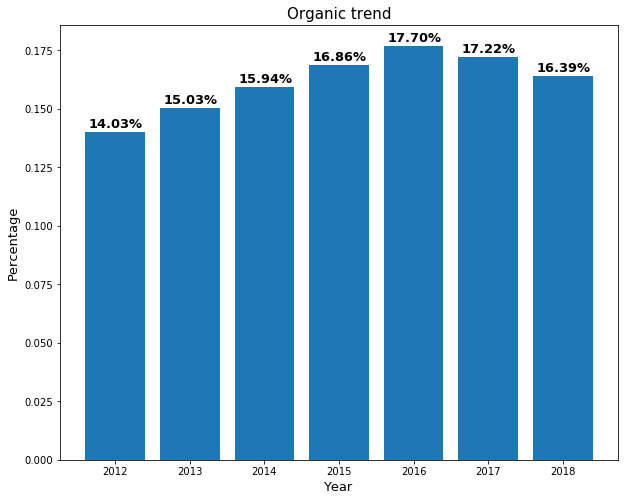

In [432]:
plot_proportion_year(['organic'], lemmatized, min_date="2012-01-01", max_date="2018-05-01", title="Organic trend")

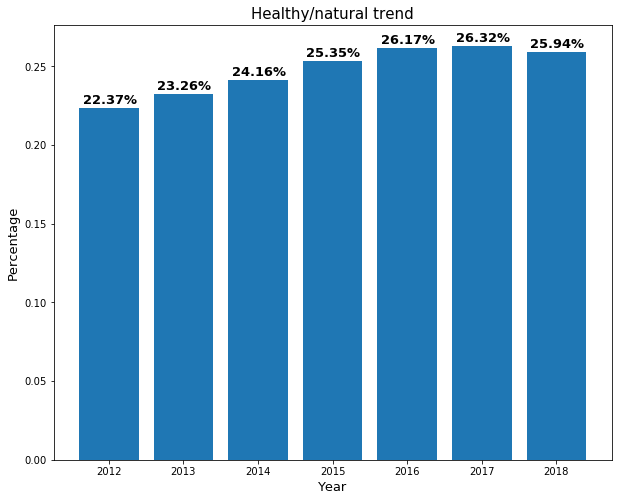

In [433]:
plot_proportion_year(healthy_natural, lemmatized, min_date="2012-01-01", max_date="2018-05-01", title="Healthy/natural trend")

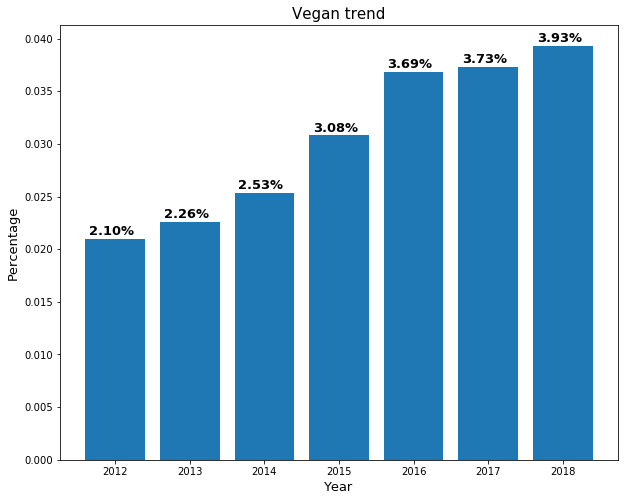

In [441]:
plot_proportion_year(["vegan"], lemmatized, min_date="2012-01-01", max_date="2018-05-01", title="Vegan trend")

In [437]:
model.wv.most_similar("vegan")

[('paleo', 0.6476948261260986),
 ('vegetarian', 0.6444412469863892),
 ('free', 0.5533650517463684),
 ('dairy', 0.5520576238632202),
 ('macrobiotic', 0.5406823754310608),
 ('kosher', 0.5009424090385437),
 ('meatless', 0.48905885219573975),
 ('gluten', 0.48391473293304443),
 ('keto', 0.47356978058815),
 ('rawtella', 0.47279608249664307)]

In [438]:
model.wv.most_similar("vegetarian")

[('vegan', 0.6444412469863892),
 ('meatless', 0.5380163788795471),
 ('suitable', 0.5358082056045532),
 ('paleo', 0.4771255552768707),
 ('celiacs', 0.4654940962791443),
 ('keto', 0.4511489272117615),
 ('coeliacs', 0.445165753364563),
 ('option', 0.43147051334381104),
 ('tofu', 0.4249204695224762),
 ('gmos', 0.4150870442390442)]

In [442]:
model.wv.most_similar("paleo")

[('keto', 0.7024561166763306),
 ('vegan', 0.6476948261260986),
 ('primal', 0.57138991355896),
 ('caveman', 0.539459764957428),
 ('eats', 0.5222615003585815),
 ('gf', 0.5082199573516846),
 ('earnest', 0.49826401472091675),
 ('gluten', 0.4954022169113159),
 ('diabetic', 0.49053990840911865),
 ('paleokrunch', 0.4865448474884033)]

In [443]:
model.wv.most_similar("keto")

[('paleo', 0.7024561166763306),
 ('diabetic', 0.6155456304550171),
 ('ketogenic', 0.5775694847106934),
 ('primal', 0.5002148151397705),
 ('atkins', 0.48262137174606323),
 ('lc', 0.47709721326828003),
 ('restrict', 0.47593754529953003),
 ('index', 0.4749963581562042),
 ('vegan', 0.47356978058815),
 ('glycemic', 0.4698601961135864)]

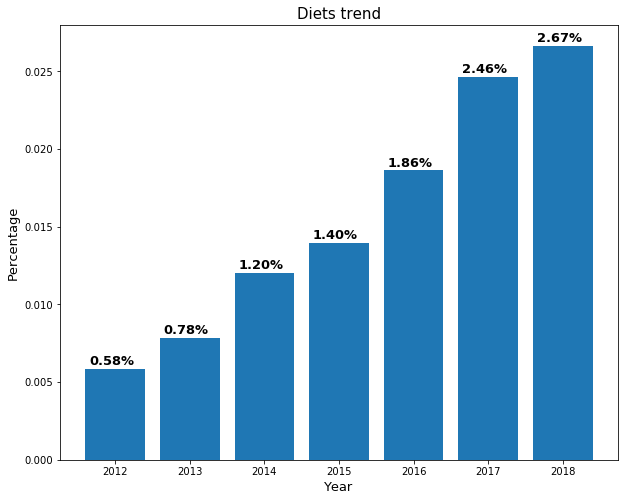

In [444]:
plot_proportion_year(["paleo", "keto", "ketogenic", "atkins"], lemmatized, min_date="2012-01-01", max_date="2018-05-01", title="Diets trend")

In [446]:
model.wv.most_similar("gluten")

[('guilt', 0.5955709218978882),
 ('cholesterol', 0.5949349403381348),
 ('rbgh', 0.5515576601028442),
 ('cage', 0.5482228994369507),
 ('sulfite', 0.5409092903137207),
 ('dairy', 0.5329529047012329),
 ('yeswheat', 0.530219554901123),
 ('yesvegan', 0.5092111825942993),
 ('flowing', 0.5069690942764282),
 ('paleo', 0.4954022169113159)]

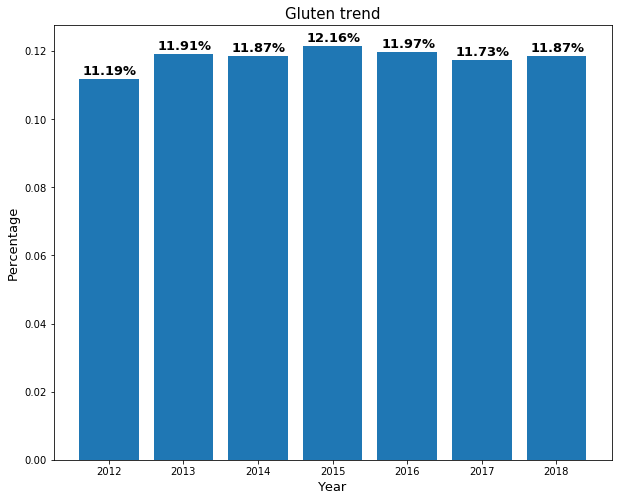

In [447]:
plot_proportion_year(["gluten", "glycemic", "cholesterol"], lemmatized, min_date="2012-01-01", max_date="2018-05-01", title="Gluten trend")

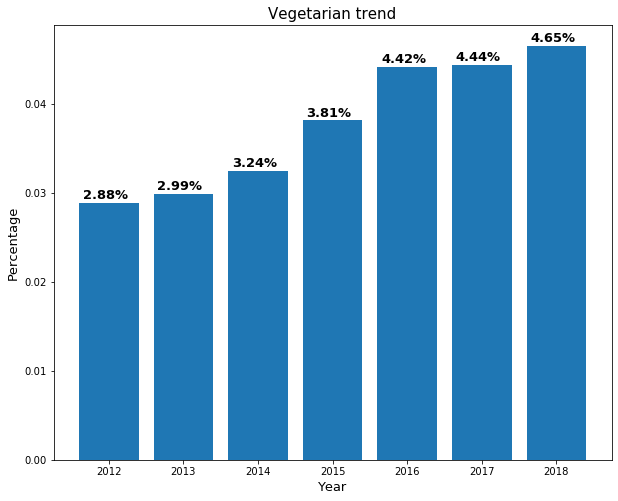

In [448]:
plot_proportion_year(["vegetarian", "tofu", "vegan", "meatless"], lemmatized, min_date="2012-01-01", max_date="2018-05-01", title="Vegetarian trend")

In [450]:
model.wv.most_similar("cholesterol")

[('freegluten', 0.6284088492393494),
 ('fat', 0.6144609451293945),
 ('gluten', 0.5949349403381348),
 ('monosaturated', 0.585191547870636),
 ('unnecessary', 0.5594995617866516),
 ('radical', 0.5568515658378601),
 ('unsaturated', 0.5567831993103027),
 ('ldl', 0.5555282831192017),
 ('lower', 0.5500462055206299),
 ('gmos', 0.5401340126991272)]

In [453]:
model.wv.most_similar("unsaturated")

[('monounsaturated', 0.8816452026367188),
 ('polyunsaturated', 0.8750534057617188),
 ('monosaturated', 0.8404529094696045),
 ('saturate', 0.7368655204772949),
 ('burner', 0.7016527652740479),
 ('reduced', 0.6708611249923706),
 ('saturated', 0.6594866514205933),
 ('diesters', 0.6508392691612244),
 ('jb', 0.6412285566329956),
 ('bastard', 0.6201952695846558)]

In [457]:
model.wv.most_similar("fat")

[('fatsno', 0.7055143713951111),
 ('fats', 0.6329742670059204),
 ('cholesterol', 0.6144609451293945),
 ('gorduras', 0.6119832992553711),
 ('methoxyl', 0.5999490022659302),
 ('lactose', 0.588330864906311),
 ('freeno', 0.5856095552444458),
 ('fibra', 0.555942177772522),
 ('saturadas', 0.5459828972816467),
 ('ldl', 0.5238897204399109)]

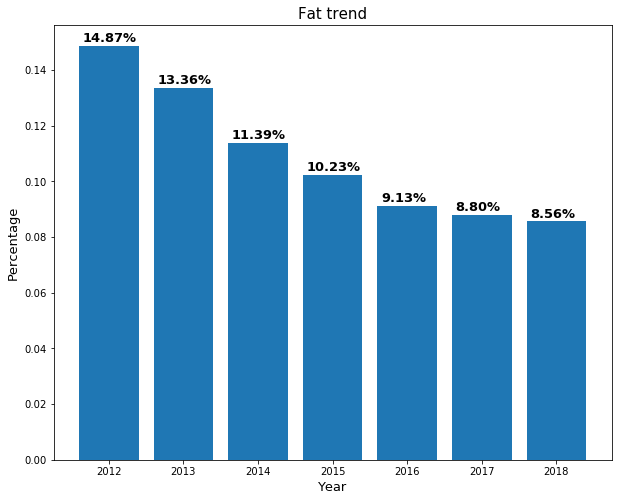

In [455]:
plot_proportion_year(["fat"], lemmatized, min_date="2012-01-01", max_date="2018-05-01", title="Fat trend")

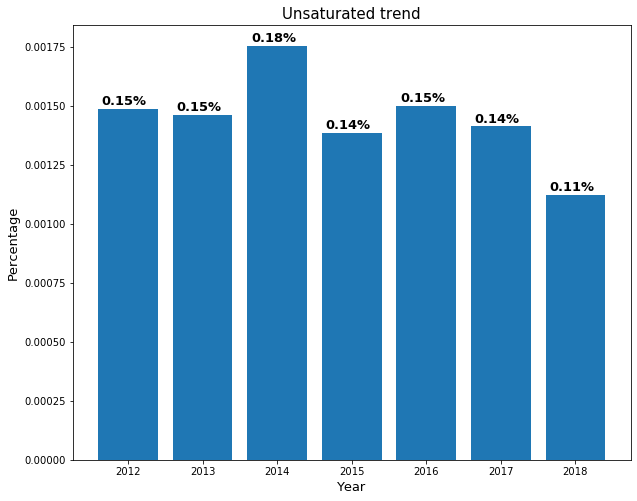

In [454]:
plot_proportion_year(["unsaturated", "monounsaturated", "polyunsaturated", "monosaturated"], lemmatized, min_date="2012-01-01", max_date="2018-05-01", title="Unsaturated trend")

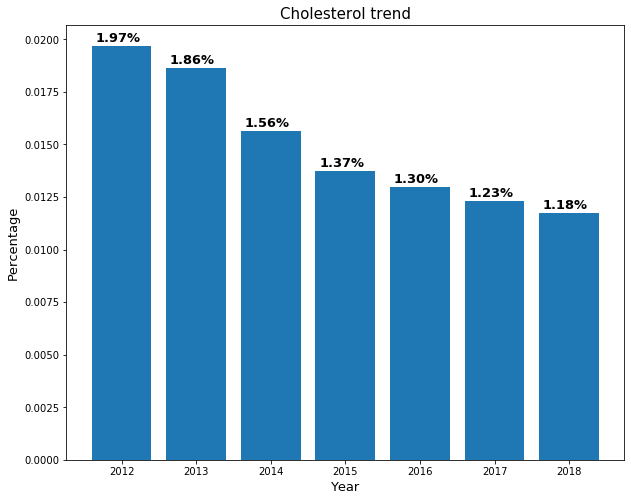

In [456]:
plot_proportion_year(["cholesterol"], lemmatized, min_date="2012-01-01", max_date="2018-05-01", title="Cholesterol trend")

In [404]:
plot_difference_total(["soy"], "soy2", lemmatized)

/home/lulu/EPFL/MA1/Ada/Project/milestone-2-plots/soy2.html

In [324]:
plot_proportion(["soy"], "soy", lemmatized)

/home/lulu/EPFL/MA1/Ada/Project/milestone-2-plots/soy.html

In [325]:
plot_proportion(["zero-proof", "zero proof"], "zero", lemmatized)

/home/lulu/EPFL/MA1/Ada/Project/milestone-2-plots/zero.html

In [326]:
plot_proportion(["quinoa", "blend burger", "mushroom"], "ors", lemmatized)

/home/lulu/EPFL/MA1/Ada/Project/milestone-2-plots/ors.html

In [327]:
plot_proportion(["ginger"], "ginger", lemmatized)

/home/lulu/EPFL/MA1/Ada/Project/milestone-2-plots/ginger.html

In [312]:
plot_proportion(["zero"], "zero", lemmatized)

,count_total,count_interest,proportion_interest,proportion_total
reviewTime,,,,
2000-06-19,1,NaN,0.000000,1.0
2000-08-09,1,NaN,0.000000,1.0
2000-12-05,1,NaN,0.000000,1.0
2001-03-28,1,NaN,0.000000,1.0
2001-07-05,1,NaN,0.000000,1.0
...,...,...,...,...
2018-10-02,30,1.0,0.033333,1.0
2018-10-03,9,NaN,0.000000,1.0
2018-10-04,7,NaN,0.000000,1.0


/home/lulu/EPFL/MA1/Ada/Project/milestone-2-plots/zero.html

In [ ]:
plot_difference_total(["organic"], "organic")

In [94]:
plot_difference_total(healthy_natural, "healthy_natural")

/home/lulu/EPFL/MA1/Ada/Project/milestone-2-plots/healthy_natural.html

In [98]:
plot_difference_total(['vegan', 'animal-rights', 'animal rights'], "vegan")

/home/lulu/EPFL/MA1/Ada/Project/milestone-2-plots/vegan.html

In [96]:
plot_difference_total(['family', 'local', 'made in the usa'], "local")

/home/lulu/EPFL/MA1/Ada/Project/milestone-2-plots/local.html

In [97]:
plot_difference_total(['weight-loss', 'weight loss', 'morale boost', 'energy'], "sport")

/home/lulu/EPFL/MA1/Ada/Project/milestone-2-plots/sport.html

In [54]:
get_values_for_col("vegetarian/vegan")

array(['vegan'], dtype=object)

In [42]:
get_values_for_col("local")

array(['Made in the USA', 'family', 'traditional family business'],
      dtype=object)

In [43]:
get_values_for_col("country")

array(['India', 'Madras', 'France', 'USA', 'Asia', 'Pacific', 'Swiss',
       'American', 'England'], dtype=object)

In [44]:
get_values_for_col("sport/productivity")

AttributeError: Can only use .str accessor with string values!

## Show top products

In [39]:
top_products = reviews.groupby('asin').size().sort_values(ascending=False)[:40]

In [40]:
dic = {}
for asin in top_products.index:
    product = meta[meta["asin"] == asin]
    assert len(product.index) == 1
    dic[asin] = {"title": product["title"].values[0], "description": product["description"].values[0]}

In [43]:
pd.DataFrame.from_dict(dic, orient='index')

,title,description
B00BUKL666,"KIND Bars, Dark Chocolate Nuts & Sea Salt, Gluten Free, 1.4 Ounce Bars, 12 Count","These bars are where our journey started and it was simple: whole ingredients like nuts, mixed with fruits and spices bound together with honey. Allergen information: contains peanuts, tree nuts a..."
B00542YXFW,"Davidson's Tea Bulk, Anise Seed, 16-Ounce Bag","Mild, but round and full licorice flavor and aroma. Anise seeds*. (*denotes organic)"
B008QMX2SG,"Kind Bars, Madagascar Vanilla Almond, Gluten Free, Low Sugar, 1.4oz","These bars are where our journey started and it was simple: whole ingredients like nuts, mixed with fruits and spices bound together with honey. Allergen information:Contains peanuts and tree nuts..."
B00D3M2QP4,"KIND Bars, Dark Chocolate Chili Almond, Gluten Free, 1.4 Ounce Bars, 12 Count","These bars are where our journey started and it was simple: whole ingredients like nuts, mixed with fruits and spices bound together with honey. Allergen information: contains peanuts, tree nuts a..."
B000YN2GVY,"Bragg Organic Unfiltered Apple Cider Vinegar, Raw, 16 Ounce - 1 Pack","Certified Bragg Organic Raw Apple Cider Vinegar is unfiltered, unheated and unpasteurized. Aged in wood, this Apple Cider Vinegar is a wholesome way to add a delicious flavor to most foods, salads..."
B000X3TPHS,"YumEarth Organic Lollipops, Assorted Flavors, 50 Lollipops","Our pops are tops! YumEarth Organic Lollipops are our signature candy. We built our company on these little suckers that are made with simple ingredients and proud to be USDA Organic, Kosher, Vega..."
B01E5XTW24,"Green Mountain Coffee, Breakfast Blend Decaf, Single-Serve Keurig K-Cup Pods, Light Roast, 96-Count (4 Boxes of 24 Pods)","An eye-opening decaf as delightful as the dawn itself. Clean and bright, with balanced sweetness, nutty flavor, and a silky mouthfeel. Bundle contains four 24-count pod boxes. 96 k Cups Green Moun..."
B000F4DKAI,"Twinings of London English Afternoon Black Tea Bags, 20 Count (Pack of 6)","First started as much needed refreshment between lunch and dinner, afternoon tea is now an important fixture of British life. Twinings English Afternoon Tea is bright in color with a brisk and ref..."
B0001LO3FG,"Twinings of London Pure Camomile Herbal Tea Bags, 20 Count","Camomile herb teas has long been a European favorite, with its light clean flavor and soothing effect. One of the most widely used herbs in the world today, camomile was first discovered by the Eg..."
B000EVMNMI,"Haribo Gummi Candy, Happy-Cola, 5-Pound Bag",Happy ColaWhat exactly puts the Happy in HARIBO Happy Cola? Is it the little chewy bottle shape it comes in? Is it the cool cola taste? Is it the good times shared over Happy Cola with old friends...


In [21]:
to_label = meta[["asin", "title", "description"]]
to_label

,asin,title,description
0,0681727810,Beemster Gouda - Aged 18/24 Months - App. 1.5 Lbs,BEEMSTER GOUDA CHEESE AGED 18/24 MONTHS
1,0853347867,Trim Healthy Mama Xylitol,"Shipped from UK, please allow 10 to 21 business days for arrival. ex lib pub by Applied Science ..."
2,1888861118,Letter C - Swarovski Crystal Monogram Wedding Cake Topper Letter,Jazz up your cakes with a sparkling monogram from our Sparkling collection! These single letter ...
3,1888861517,Letter H - Swarovski Crystal Monogram Wedding Cake Topper Letter,"Large Letter - Height 4.75"""
4,1888861614,Letter S - Swarovski Crystal Monogram Wedding Cake Topper Letter,"4.75"""
...,...,...,...
287204,B01HJFBN9A,"Caffarel Fruit Jellies, Organic Assorted, 200 g Bag","Caffarel fruit jellies are a product of Italy. Caffarel fruit jellies, organic assorted, 200 gra..."
287205,B01HJFC704,"HAMPTON CREEK Spo Just Truffle Mayo, 12 Ounce",Hampton Creeks Just Mayo Truffle makes fancy food as simple as the sandwich youre about to put i...
287206,B01HJF6FRA,"HAMPTON CREEK Just Ranch Dressing, 12 Fluid Ounce",Nothing compares with the classically zesty flavor of Hampton Creeks Just Ranch creamy and savo...
287207,B01HJHSVG6,"Gourmet Pure Vanilla Bean Pastes - Organically Grown, Contains Whole Vanilla Seeds from Hand Pic...",


In [22]:
sample = to_label.sample(5000, random_state=912)
sample

,asin,title,description
30946,B00122CNFU,"Cajun King Barbecued Shrimp Seasoning Mix, 1-Ounce Packages (Pack of 24)",Be sure to have lots of French Bread around to sop up all the good juices left over after you ea...
69278,B0046LF9IM,"Roland Curry Powder, Madras, 1 Pound (Pack of 4)",Our mission is to be the leader in importing and marketing superior quality specialty foods unde...
38747,B001E5E3AS,"Erewhon Barley Plus, Organic Hot Cereal, 14-Ounce Boxes (Pack of 6)","A hearty hot cereal made from organically grown barley, oat bran, and brown rice. Erewhon Barley..."
196638,B00KDLMEFA,Simply Right Allergy Multi-symptom Relief: 600 Cool Caplets with Cool Blast Flavor,
94359,B005R6T6BQ,Delight Expressions™ Peek-a-boo! Halloween Gift Basket - For Kids - For Her - For Him,This candy and chocolate boo-quet is frightfully filled with spook-tacular sweets. Nobody will b...
...,...,...,...
268195,B019EG7L3E,"Cleveland Kraut Beet Red, 15 Ounce",Fresh fermented beets and carrots make the beet red kraut deliciously earthy and tart. Add a bea...
129774,B00B0427CE,"Pepsico Propel Mind Zero - Black Cherry, 500 Milliliter -- 24 per case.","Propel Workout Water is lightly flavored hydration to help keep you going, with zero calories an..."
209107,B00MK7QMPI,Ken's Steakhouse Marinade & Sauce: Honey Teriyaki (Pack of 5) 16 oz Bottles,
15536,B000HBMI70,"Tea Leaf Trading Company Tropical Citrus Green Tea Bags, 20-Count Boxes (Pack of 6)",Premium Chinese Green tea with balanced infusion of tropical citrus and hints of sweet pineapple...


In [23]:
sample["title"][sample["title"].str.contains('function', regex=False)]

Series([], Name: title, dtype: object)

## Country

In [104]:
labels[labels["country"].notnull()]

,asin,title,description,healthy/natural,vegetarian/vegan,local,sport/productivity,country
1,B0046LF9IM,"Roland Curry Powder, Madras, 1 Pound (Pack of 4)","Our mission is to be the leader in importing and marketing superior quality specialty foods under our Roland brand and other brands, and to perform in all areas of our organization at levels that ...","superior quality, highest standards",NaN,NaN,NaN,"India, Madras"
6,B001FA1KN0,NaN,"All natural. Fat free, cholesterol free, and sodium free. Product of France. Chestnuts.","all natural, fat free, cholesterol free, sodium free",NaN,NaN,NaN,France
11,B001979YRI,"Oskri Date Fruit Bar, Gluten Free, 1.5-Ounce Bars (Pack of 20)","Gluten free. Lactose free. Oskri Organics is committed to offering the best products that are grown and prepared in a natural way, without the use of chemical fertilizers, insecticides, and herbic...","gluten free, lactose free, Organics, natural way, without chemical fertilizers, without insecticides, without herbicides",NaN,Made in the USA,NaN,USA
14,B001EQ543M,NaN,"Asia/Pacific: Coffees from Asia/Pacific are full-flavored with characteristics that range from the assertive, herbal spiciness and depth that typify the semi-washed coffees of Indonesia to the bal...",NaN,NaN,NaN,NaN,"Asia, Pacific"
20,B00B8BQ3ZG,Hormel Compleats Cafe Creations Three Cheese Chicken Pasta 9 oz,"Inspected for wholesomeness by U.S. Department of Agriculture. Infused with unique seasonings & flavors. Feeling adventurous? Try all our exciting recipes! Water, Pasta (Durum Wheat, Water, Egg Wh...",NaN,NaN,NaN,NaN,"Swiss, American"
22,B000F3XZEK,"Taylors of Harrogate, Gunpowder Tea, Loose, 35.3 Ounce","Speciality Leaf Tea. Family tea merchants. Est. 1886. We are a traditional family business, based in England's beautiful Yorkshire Dales. For over a century we've taken pride in selecting the very...","antioxidants, very best, with care",NaN,"family, traditional family business",NaN,England


In [179]:
countries = ["switzerland|swiss", "italy|italian", "japan|japanese", "china|chinese", "england|english", "mexico|mexican", "india|indian", "german"]

In [136]:
from math import ceil

In [168]:
lemmatized = pd.read_csv('./processed-data/meta_lemm.csv')

In [169]:
lemmatized

,Unnamed: 0,category,description,title,brand,rank,main_cat,price,asin,date
0,0,"Grocery & Gourmet Food||Dairy, Cheese & Eggs||Cheese||Gouda",beemster gouda cheese age month,beemster gouda age month app lb,Ariola Imports,"165,181inGroceryGourmetFood(",Grocery,41.91,0681727810,NaN
1,1,Grocery & Gourmet Food||Cooking & Baking||Sugar Substitutes||Xylitol,ship uk please allow business day arrival ex lib pub apply science publisher ltd,trim healthy mama xylitol,NaN,"315,867inGroceryGourmetFood(",Grocery,NaN,0853347867,NaN
2,2,"Grocery & Gourmet Food||Cooking & Baking||Frosting, Icing & Decorations||Cake & Cupcake Toppers||Cake Toppers",jazz cake sparkle monogram sparkle collection single letter monogram silver plat covered crystal rhinestone come several size convenience use simple yet elegant monogram cake topper make sweet eve...,letter swarovski crystal monogram wed cake topper letter,Unik Occasions,">#669,941 in Kitchen & Dining (See Top 100 in Kitchen & Dining)>#9,899 in Kitchen & Dining > Bakeware > Decorating Tools > Cake & Cupcake Toppers > Cake Toppers",Amazon Home,29.95,1888861118,2010-09-21
3,3,"Grocery & Gourmet Food||Cooking & Baking||Frosting, Icing & Decorations||Cake & Cupcake Toppers||Cake Toppers",large letter height,letter swarovski crystal monogram wed cake topper letter,Other,">#832,581 in Kitchen & Dining (See Top 100 in Kitchen & Dining)>#12,883 in Kitchen & Dining > Bakeware > Decorating Tools > Cake & Cupcake Toppers > Cake Toppers",Amazon Home,11.45,1888861517,2011-09-11
4,4,"Grocery & Gourmet Food||Cooking & Baking||Frosting, Icing & Decorations||Cake & Cupcake Toppers||Cake Toppers",NaN,letter swarovski crystal monogram wed cake topper letter,Unik Occasions,">#590,999 in Kitchen & Dining (See Top 100 in Kitchen & Dining)>#8,585 in Kitchen & Dining > Bakeware > Decorating Tools > Cake & Cupcake Toppers > Cake Toppers",Amazon Home,15.00,1888861614,2011-09-11
...,...,...,...,...,...,...,...,...,...,...
283507,287204,"Grocery & Gourmet Food||Jams, Jellies & Sweet Spreads||Jams, Jellies & Preserves",caffarel fruit jelly product italy caffarel fruit jelly organic assorted gram bag assort fruit jelly ingredients sugar glucose fructose syrup water concentrate fruit juice cherry raspberry blueber...,caffarel fruit jelly organic assorted bag,Caffarel,"369,384inGroceryGourmetFood(",Grocery,NaN,B01HJFBN9A,NaN
283508,287205,Grocery & Gourmet Food||Condiments & Salad Dressings||Mayonnaise,hampton creeks mayo truffle make fancy food simple sandwich youre put perfect way take favorite food next level subtle earthy flavor wont want skimp make meal memorable mayo truffle number contain...,hampton creek spo truffle mayo ounce,Hampton Creek,"113,710inGroceryGourmetFood(",Grocery,10.89,B01HJFC704,NaN
283509,287206,Grocery & Gourmet Food||Condiments & Salad Dressings||Salad Dressings||Ranch,nothing compare classically zesty flavor hampton creeks ranch creamy savory hard resist make dress choice whether youre salad fiend dunk favorite food flavor perfect ranch never go style ranch sat...,hampton creek ranch dress fluid ounce,Hampton Creek,"21,731inGroceryGourmetFood(",Grocery,10.95,B01HJF6FRA,NaN
283510,287207,"Grocery & Gourmet Food||Herbs, Spices & Seasonings||Single Herbs & Spices||Vanilla Beans",NaN,gourmet pure vanilla bean paste organically grown contains whole vanilla seed hand pick heilala vanilla pod natural superior tahitian mexican madagascar paste,Heilala Vanilla,472inGroceryGourmetFood(,Grocery,14.97,B01HJHSVG6,NaN


In [275]:
def check_country_interest(keywords, meta_df, model):
    nrows = ceil(len(keywords)/2)
    ncols = 2
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols)
    fig.set_size_inches((10*ncols,8*nrows))
    
    for i, keyword in enumerate(keywords):
        products = meta_df[['title', 'description']][(meta_df["title"].str.contains(keyword)) |\
                                                     (meta_df["description"].str.contains(keyword))]
        counts = [
            len(products[(products['title'].str.contains(country)) |\
                        (products['description'].str.contains(country))].index)
            for country in countries
        ] 
        similarities = np.array([
            model.wv.n_similarity(country.split('|'), [keyword])
            for country in countries
        ]).clip(0, 1)
        
        row = i//2
        col = i % 2
        width = 0.35
        indx = np.arange(len(countries))
        
        ax = axs[row,col]
        ax2 = axs[row,col].twinx()
        
        ax.set_xticklabels(["padding"] + [country.split('|')[0] for country in countries], rotation=30, fontsize=13)
        ax.set_title(f"Country count for {keyword}", fontsize=15)
        
        l1 = ax.bar(indx - width/2, counts, width=width, label="count")
        ax.set_ylabel("Count", fontsize=13)
        l2 = ax2.bar(indx + width/2, similarities, color='red', width=width, label="similarity")
        ax2.set_ylim(0,1)
        ax2.set_ylabel("Word2Vec similarity", fontsize=13)
        
        plt.legend(handles=[l1, l2])
    
    plt.show()

In [276]:
model.wv.n_similarity(["switzerland", "swiss"], ["coffee"])

0.2388226

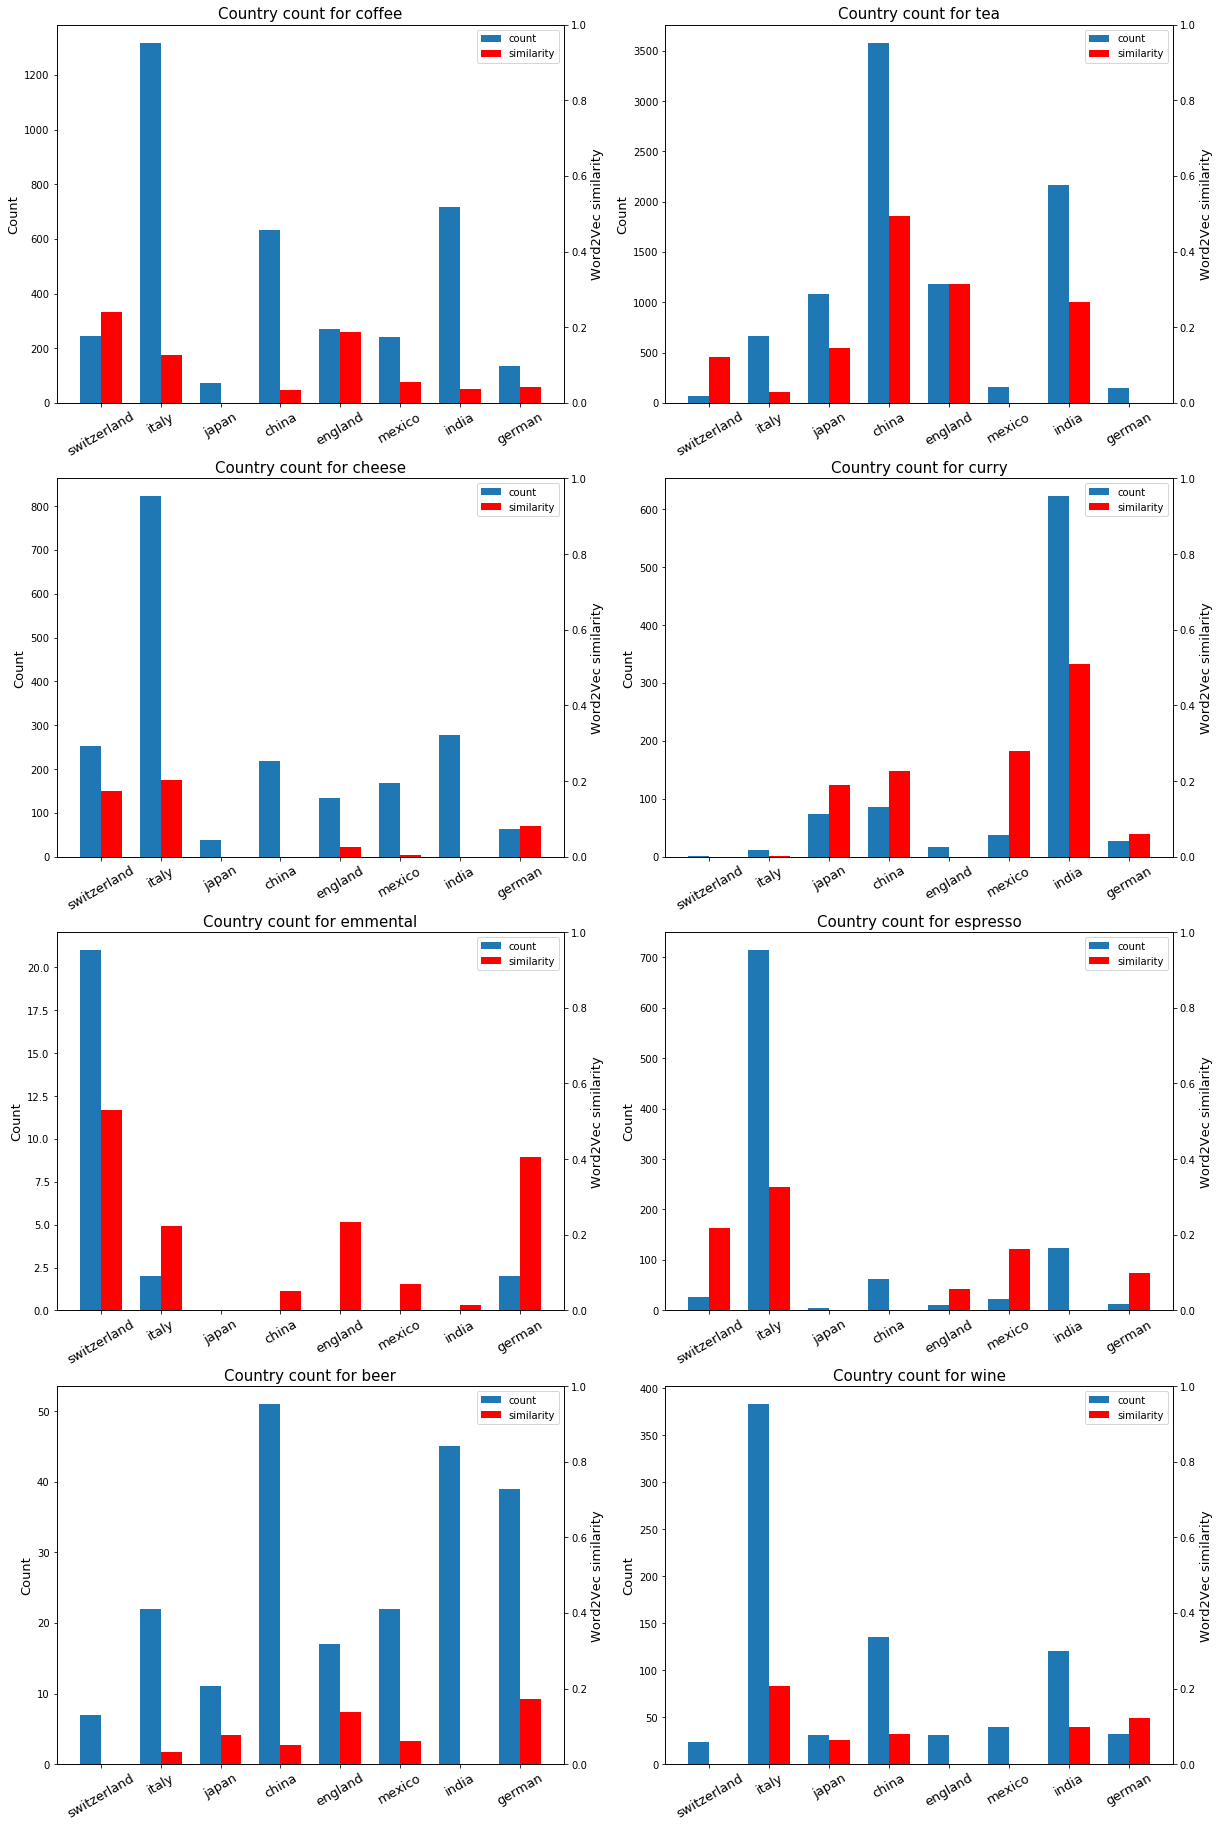

In [313]:
check_country_interest(["coffee", "tea", "cheese", "curry", "emmental", "espresso", "beer", "wine"], lemmatized, model)

In [ ]:
check_country_interest(["coffee"])

In [24]:
def check_word(word):
    size = sample[(sample["description"].str.lower().str.contains(word)) | (sample["title"].str.lower().str.contains(word))].size
    print(f"{word}: {size}")

In [25]:
check_word("chin")
check_word("swiss")
check_word("ital")
check_word("mexi")
check_word("german")
check_word("japan")
check_word("fit")
check_word("healthy")
check_word("vegan")
check_word("vege")
check_word("energy")
check_word("local")
check_word("organic")
check_word("natural")
check_word("100%")

chin: 447
swiss: 66
ital: 504
mexi: 168
german: 87
japan: 144
fit: 309
healthy: 525
vegan: 219
vege: 777
energy: 207
local: 198
organic: 1599
natural: 2868
100%: 792


In [26]:
sample.to_csv('sample-data.csv', header=False, index=False)

In [26]:
meta[["title", "description"]].loc[:1000,:].to_csv('test_data.csv', header=False, index=False)

In [21]:
cheese_products = meta["description"][meta["description"].str.lower().str.contains("cheese")]

In [22]:
cheese_products.str.lower().str.contains("swiss").sum()

279

In [23]:
cheese_products.str.lower().str.contains("ital").sum()

1353

In [45]:
cheese_products.str.lower().str.contains("mexi").sum()

233

In [55]:
cheese_products.str.lower().str.contains("japan").sum()

59

In [56]:
cheese_products.str.lower().str.contains("chin").sum()

277

In [41]:
tea_products = meta["description"][meta["description"].str.lower().str.contains("tea")]

In [48]:
tea_products.str.lower().str.contains("chin").sum()

4075

In [49]:
tea_products.str.lower().str.contains("japan").sum()

1064

In [52]:
tea_products.str.lower().str.contains("ital").sum()

1735

In [53]:
tea_products.str.lower().str.contains("mexi").sum()

399

In [54]:
tea_products.str.lower().str.contains("swiss").sum()

91

In [ ]:
meta["description"].to_list()

In [21]:
import random
from collections import Counter
import spacy

In [29]:
nlp = spacy.load('en')

In [37]:
nlp.max_length = 893274040

In [22]:
texts = reviews["reviewText"].to_list()

In [ ]:
texts

In [25]:
text = " ".join(texts)

In [27]:
type(text)

str

'Very pleased with my purchase. Looks exactly like the picture and will look great on my cake. It def'

In [30]:
count = Counter(text.split(' '))

In [36]:
counts = count.most_common()

In [38]:
len(counts)

1890338

In [44]:
with open('your_file.txt', 'w') as f:
    for item in counts:
        #print(item)
        f.write("(%s, %s)\n" % (item[0], item[1]))

In [56]:
df_c = pd.DataFrame(counts)

In [52]:
import spacy, nltk, gensim, sklearn
import pyLDAvis.gensim

In [54]:
spacy.load('en')

In [55]:
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS

In [60]:
df_c.columns = ["word", "count"]

In [63]:
df_c[~(df_c['word'].isin(spacy_stopwords))].to_csv('counts_stopword', index=False)

In [ ]:
count.most_common(1000)

In [40]:
len(texts)

5074160

In [ ]:
word_freq.most_common()

In [22]:
long_reviews = pd.Dcollectionsrame(reviews["reviewText"][reviews["reviewText"].str.len() > 70])

In [ ]:
long_reviews["reviewText"].to_list()

## Feature distribution analysis

Now let's see what the reviews look like on a broad view. As they'll be our main source of data for analysis we need to have a good idea of how they are.

The features that are the most interesting are `stars`, `verified`, `reviewTime`, `reviewText` and `upvote`. A recap of what they mean:
- `stars`: How a product was appreciated
- `verified`: If the purchase has been verified, 
- `reviewTime`: The day the review has been posted
- `reviewText`: The content of the review
- `upvote`: The number of upvotes/helpful on a review

Of course all the feature we have are of some interest, but these ones are the most interesting, so we'll take a look at them in more detail.

First, let's see some information about `stars` and `upvote`

In [21]:
reviews.describe()

,stars,upvote
count,5.074160e+06,5.074160e+06
mean,4.314708e+00,8.295479e-01
std,1.249303e+00,1.206719e+01
min,1.000000e+00,0.000000e+00
25%,4.000000e+00,0.000000e+00
50%,5.000000e+00,0.000000e+00
75%,5.000000e+00,0.000000e+00
max,5.000000e+00,1.217400e+04


As you can see a vast majority of reviews don't have any upvotes, and most of the reviews give a high amount of stars, 25% percentile is already at 4 stars! The number of upvotes probably follows a power law, let's plot them to verify!

In [27]:
def plot_bar_distribution(data, title, xlabel, ylabel, yscale='linear', width=0.8, figsize=(12, 8), categorical=False):
    counts = np.bincount(data)
    values = np.nonzero(counts)[0]
    counts = counts[values]
    
    plt.figure(figsize=figsize)
    plt.bar(values, counts, width=width)
    if categorical:
        plt.xticks(values)
    plt.title(title, fontsize=15)
    plt.xlabel(xlabel, fontsize=13)
    plt.ylabel(ylabel, fontsize=13)
    plt.yscale(yscale)
    plt.show()

In [16]:
def plot_ccdf_power_law(data, title, xlabel, ylabel, xmin=0, discrete=True, figsize=(10,8)):
    fit = powerlaw.Fit(data, xmin=xmin, discrete=discrete)
    plt.figure(figsize=figsize)
    ax = plt.gca()
    fit.power_law.plot_ccdf(color='b', linestyle='--', label='fit ccdf', ax=ax)
    fit.plot_ccdf(color='b', label='actual ccdf', ax=ax)
    plt.title(title, fontsize=15)
    plt.xlabel(xlabel, fontsize=13)
    plt.ylabel(ylabel, fontsize=13)
    plt.legend()
    plt.show() 

We will plot the number of stars

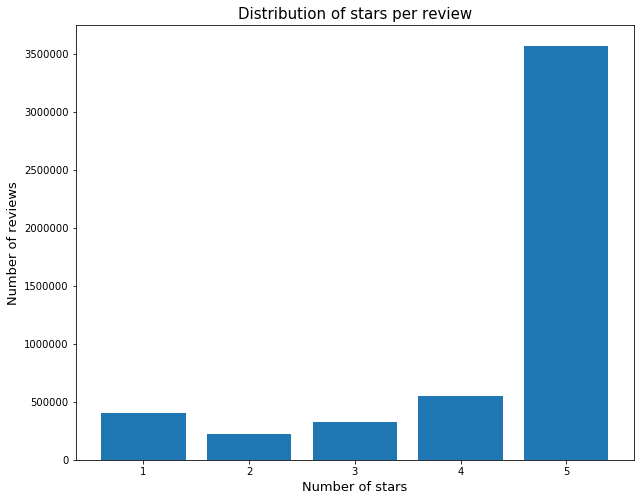

In [29]:
plot_bar_distribution(reviews['stars'],\
                      title="Distribution of stars per review",\
                      xlabel="Number of stars",\
                      ylabel="Number of reviews",\
                      figsize=(10,8),\
                      categorical=True)

As you can see a vast majority of reviews give 5 stars, but there are more 1 star than 2 or 3 stars, which is intersting. We can see that people usually review in the extreme either they think it's good so they give 4 or 5, or they thought it's trash and give 1.

Let's now take a look at `verified`.

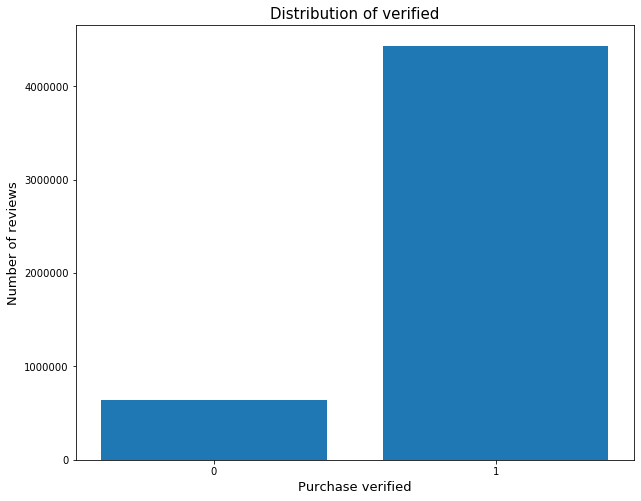

In [41]:
plot_bar_distribution(reviews['verified'],\
                      title="Distribution of verified",\
                      xlabel="Purchase verified",\
                      ylabel="Number of reviews",\
                      figsize=(10,8),\
                      categorical=True)

This is interesting and good news! As we can see most of the reviews are verified, so most of the reviews come from people that actually bought the product.

Let's plot the distribution of upvotes and compare it with the power law.

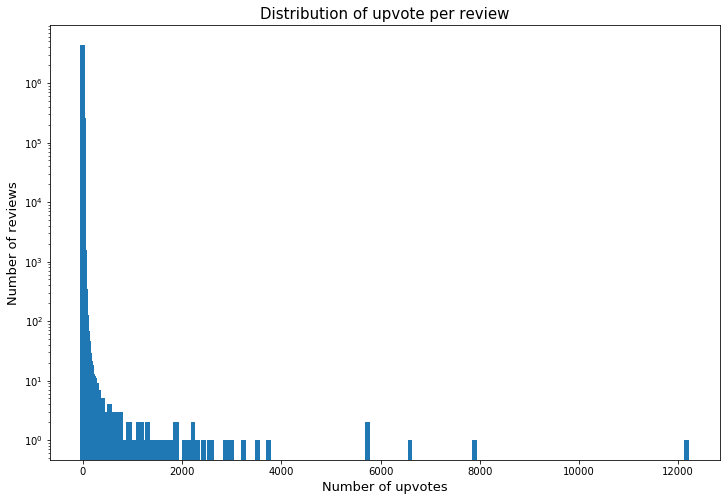

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/home/lulu/.venv/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in true_divide
  (CDF_diff**2) /
/home/lulu/.venv/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning: divide by zero encountered in true_divide
  (CDF_diff**2) /


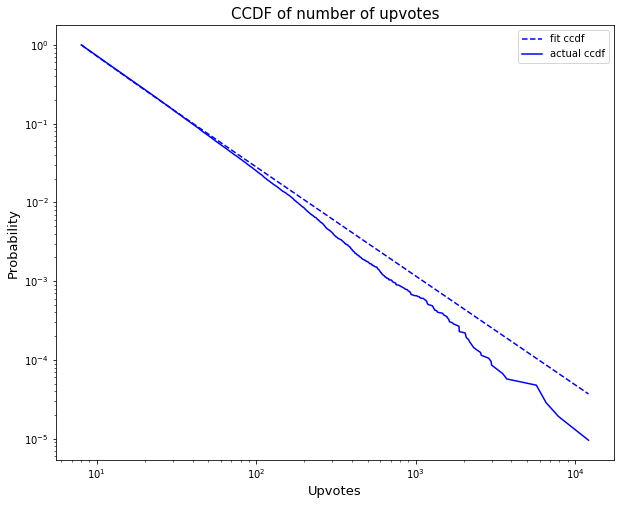

In [30]:
plot_bar_distribution(reviews['upvote'],\
                      title="Distribution of upvote per review",\
                      xlabel="Number of upvotes",\
                      ylabel="Number of reviews",\
                      yscale="log",\
                      width=100)

plot_ccdf_power_law(reviews['upvote'],\
                    title="CCDF of number of upvotes",\
                    xlabel="Upvotes",\
                    ylabel="Probability")

We can see that it indeed follows a power law, most of the reviews have 0 upvotes, but there are some with a high amount of upvotes.

Something to note that'll be able to see later on is that reviews with a huge amount of upvotes probably are jokes or memes. Otherwise it doesn't really make sense for a review to have so many upvotes.

Let's take a look at `reviewText` we can try to plot the distribution of the length of the reviews. It should also follow a power law.

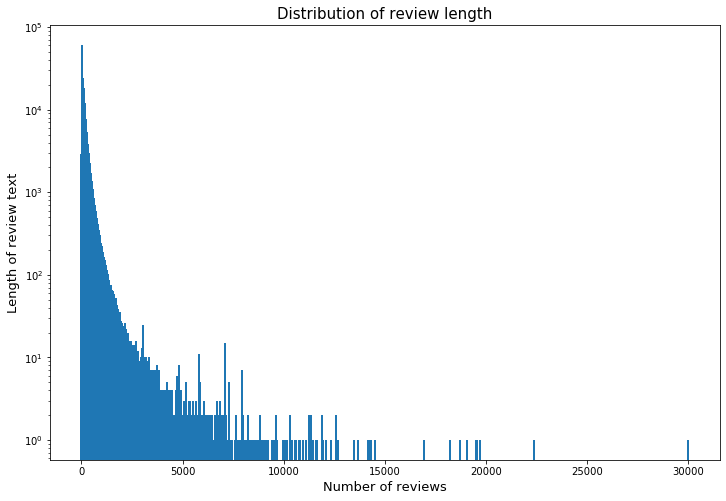

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


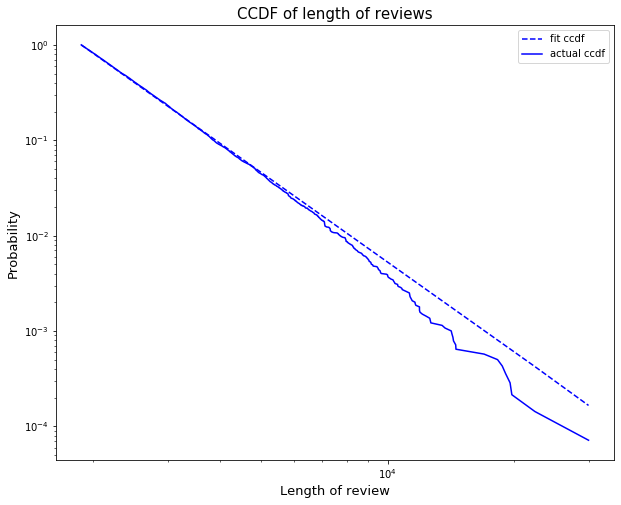

In [31]:
plot_bar_distribution(reviews['reviewText'].str.len(),\
                      title="Distribution of review length",\
                      xlabel="Number of reviews",\
                      ylabel="Length of review text",\
                      yscale="log",\
                      width=100)

plot_ccdf_power_law(reviews['reviewText'].str.len(),\
                    title="CCDF of length of reviews",\
                    xlabel="Length of review",\
                    ylabel="Probability")

Again, it follows a power law, which is to be expected.

Now let's take a look at how many reviews we have over time, using the date. This give us some information about how much reviews we have and if the number of reviews during the year is linear or constant, or on the contrary if it's varying a lot.

In [33]:
def write_plot_html(plot, file_name):
    file_name = f"{PLOTS_LOCATION}{file_name}.html"
    output_file(file_name)
    save(plot)
    return FileLink(file_name)

In [26]:
reviews_per_date = reviews[['reviewTime']].copy()
reviews_per_date = pd.DataFrame(reviews_per_date.groupby('reviewTime').size(), columns=['count'])
reviews_per_date.sort_index(inplace=True)

tools = "pan, wheel_zoom"
source = ColumnDataSource(reviews_per_date)

p = figure(plot_width=1400, plot_height=800, tools=tools, x_axis_type="datetime")
p.line('reviewTime', 'count', source=source)

write_plot_html(p, "all_reviews")

/home/lulu/EPFL/MA1/Ada/Project/milestone-2-plots/all_reviews.html

If you go to the above link (you may need to click on "Trust HTML", you can enable wheel zoom on the right and move the view by dragging), you can see that the number of reviews varies a lot during the year, but is globally increasing over time. 2015 seemed to have been a the big starting year for Amazon food category, which confirms that picking the updated 2018 dataset was a good idea since it adds a lot of data. We can also see that some dates have a lot of reviews, which we'll look into, for example March 2016. Something interesting is that our dataset ends in 2018 but as you can see it doesn't end abruptly, it decays rapidly, so we have to keep that in mind, we lack a lot of reviews in the 2018 year.

To look into it a bit deeper we can look at the distributions over year and month.

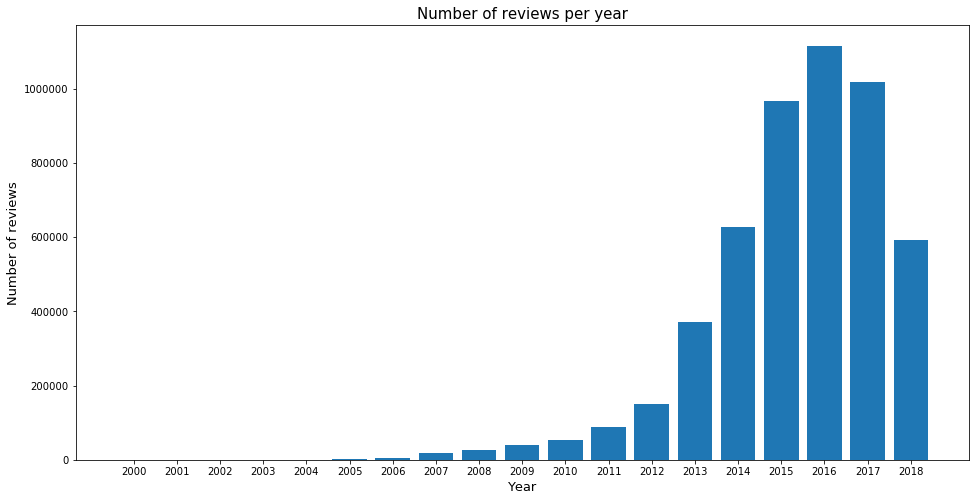

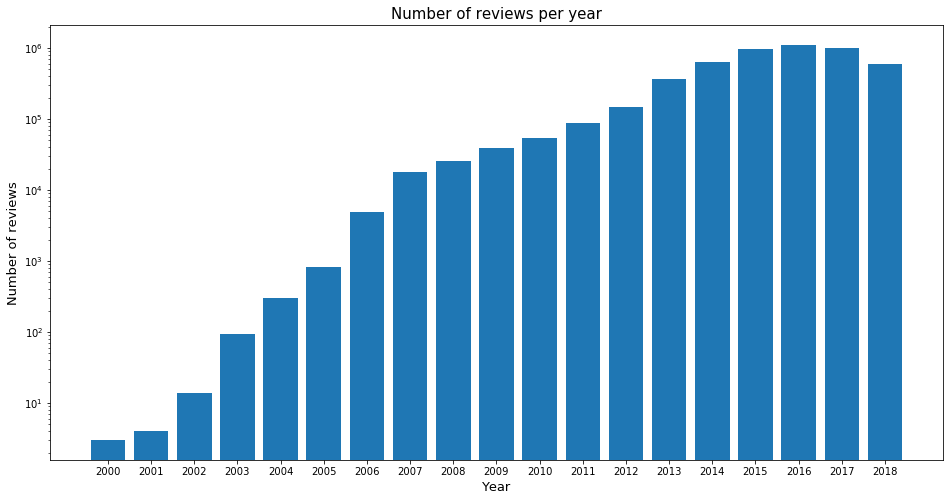

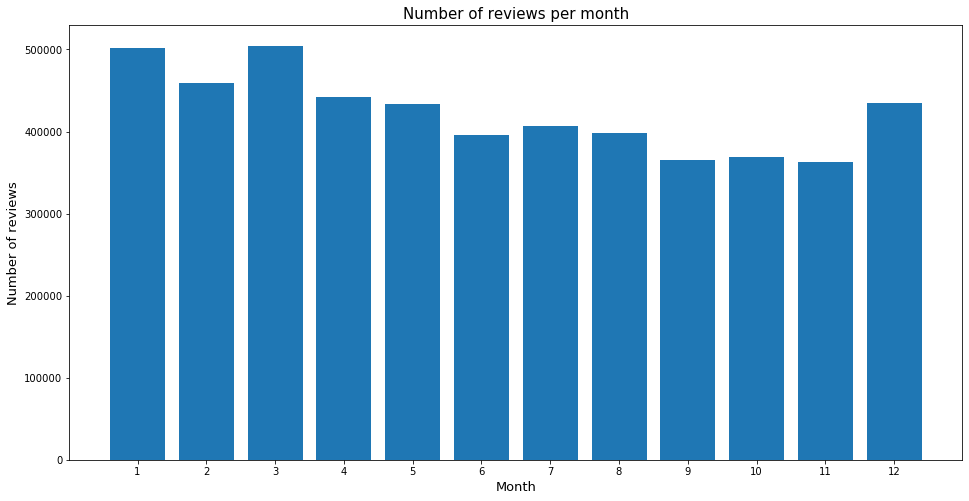

In [35]:
reviews_year = reviews['reviewTime'].map(lambda date: date.year)
args_year = {"data": reviews_year,\
             "title": "Number of reviews per year",\
             "xlabel": "Year",\
             "ylabel": "Number of reviews",\
             "figsize": (16, 8),\
             "categorical": True}

plot_bar_distribution(**args_year)
plot_bar_distribution(**args_year, yscale="log")

reviews_month = reviews['reviewTime'].map(lambda date: date.month)
plot_bar_distribution(reviews_month, title="Number of reviews per month", xlabel="Month", ylabel="Number of reviews", figsize=(16, 8), categorical=True)

As we can see, it indeed increases over the years, except 2018 as we lack reviews.

For the months it's somewhat even, but we can see that Winter is more popular, with Christmas, New Year, Valentine's Day and so on.

## Data analysis

Our goal is to find interesting effects of events and trends in our dataset. For the moment, our three main directions are:
- Measuring the distribution of the number of reviews over time for a product, thus seeing if there exists a correlation between this product and some events
- Using word embeddings to compare reviews or description of products with an event (represented by a document). Hence doing some smart document similarity to see how a trend can impact the dataset.
- Performing topic extraction on the description of a product or on the reviews to see if events result in a change in the topic distribution

Concerning the first approach, measuring correlation is good and it can lead to first results but it is not enough. What we want is to measure how much an event impact some products popularity. Or if doing natural language processing on reviews, how much the event impact the content of those reviews. For that, the correlation does not suffice. What we'll use for that is bayesian structural time series to be able to deduce causal effect on reviews and products.

The third method will not be presented for now as results are not conclusive at the moment. The idea behind it is to use a topic extraction techniques such as LDA to extract topics in the dataset. Than, we can measure how much our trend or event is present in the topics. From that, we can see how the trend or event behave over time using the evolution of the distribution of topic in the dataset. We chose not to focus on this approach for the moment, reasons are multiple for this. First of all, on which part of the dataset would it be best to run LDA? This is not trivial, by taking the dataset over a big period of time, topic would be too general, however taking a short period of time around an event for example not would yield interesting results, the analysis being restricted to that period. On top of that, training such a model takes a significant amount of time and try to run a whole lot of them so to be able to compare the results would require a lot of ressources.

We thus present below the first two approaches. We'll begin by plotting time series of the number of reviews for the products of our dataset, and gain some insights from that. We'll continue by focusing on an event and plotting time series that have interesting behaviors in the time of that event. We'll use this analysis to measure impact of events on word frequencies.


### Time series of number of reviews

In [1]:
def compute_reviews_per_week(reviews, minimum_review):
    """
    Create dataframe with number of reviews per product per week, based on the {reviews} dataframe, keep only 
    the ones that have at least {minimum_review} during a week
    """ 
    reviews_per_week = pd.DataFrame(reviews[['asin', 'reviewTime']].groupby(['asin', pd.Grouper(key='reviewTime', freq='W')]).size(), columns=['reviewCount'])
    reviews_per_week = reviews_per_week.groupby(['asin']).filter(lambda row: row.to_numpy().max() > minimum_review)
    reviews_per_week.reset_index(inplace=True)
    return reviews_per_week

In [24]:
reviews_per_week = compute_reviews_per_week(reviews, 7)

In [25]:
def plot_time_series(ids, plot_filename):
    """
    Create an interactive plot that show the evolution of the number of reviews for the 
    given products
    
    :param ids: an iterable with the ids (asin) that will be in the plot
    :param plot_filename: the filename of the produced plot
    :return: the path to the plot
    """
    tools = "pan, wheel_zoom"
    p = figure(plot_width=1400, plot_height=800, tools=tools, x_axis_type="datetime")
    num_colors = np.clip(len(ids), 3, 20)
    colors = d3['Category20'][num_colors]
    
    for i, asin in enumerate(ids):
        reviews_asin = reviews_per_week.loc[reviews_per_week['asin'] == asin, ['reviewTime', 'reviewCount']]
        reviews_asin.set_index('reviewTime', inplace=True)
        reviews_asin.sort_index(inplace=True)

        source = ColumnDataSource(reviews_asin)

        p.line('reviewTime', 'reviewCount', source=source, legend_label=str(asin), color=colors[i % 20], line_width=2, alpha=0.8)
    
    p.legend.click_policy="hide"
    
    return write_plot_html(p, plot_filename)

In [64]:
# Plot the time series of a sample (first 10'000 product) of origin dataframe
reviews_per_week_sample = reviews_per_week.loc[reviews_per_week['asin'].isin(reviews.loc[:10000, 'asin']).values, :]
plot_time_series(reviews_per_week_sample['asin'].unique(), 'time_series_first_10000')

/home/lulu/EPFL/MA1/Ada/Project/milestone-2-plots/time_series_first_10000.html

As before, this is an interactive plot for which you may have to "trust" to see. 

In [27]:
id1 = "B0000CFH7B"
id2 = "B0000D916Y"
display(meta["title"][meta["asin"] == id1].values[0])
meta["title"][meta["asin"] == id2].values[0]

'Wilton 710-5506 Color Mist Spray 1.5oz, Black'

"David's Cookies - 24 Fresh Baked M&M Candy Cookie Gourmet Gift Basket - Christmas, Holiday & Corporate Food Tin - Idea For Men & Women - Certified Kosher - 2 lb."

In [28]:
reviews_spray = reviews[["reviewTime", "reviewerID", "reviewText", "summary", "upvote", "stars", 'verified']]\
                        [(reviews["asin"] == id1) &\
                         (reviews["reviewTime"] >= pd.to_datetime("2015-05-22")) &\
                         (reviews["reviewTime"] <= pd.to_datetime("2015-06-15"))]

display(reviews_spray)
date_with_max_reviews = reviews_spray.groupby("reviewTime").agg("size").idxmax()
print(f"Date with max number of reviews: {date_with_max_reviews.date()}")

,reviewTime,reviewerID,reviewText,summary,upvote,stars,verified
4197,2015-06-15,A1Q6MV8HRC58KK,If you go back to the beginning of the reviews there are about 13 pages of nonsense about baking...,Best Shine in the Wasteland,66,5,False
4198,2015-06-13,ABD1G0MCG2QHT,"My cupcakes are all shiny and chrome. I eat, I poop, I eat again.",Five Stars,47,5,False
4199,2015-06-12,A3OX7K7TZ1A6IG,I BUY! I RETURN! I BUY AGAIN!!,Five Stars,123,5,False
4200,2015-06-12,A3N37GJGVFUDJB,Mitch has witnessed me!!!,Five Stars,11,5,False
4201,2015-06-11,ABZC6GUF3EZR9,IT BURNS OH IT BURNS WONDERFULLY\nTHE PATH TO VALHALLA IS NOT A PAINLESS ONE,SHINY AND CHROME,77,5,True
...,...,...,...,...,...,...,...
4363,2015-05-25,A2ANPUFYSVCZCM,Oh what a spray! What a lovely spray!,"So Shiny, So Chrome",3001,5,False
4364,2015-05-23,A3VM93YDITI5DK,Makes it really easy to spot a Warboy who is at the end of their half life and about to become a...,"Brightens up my world, which is fire and blood.",161,5,False
4365,2015-05-23,A1B6CBLRIA9FR1,I LIVE! I DIE! I LIVE AGAIN!,Four Stars,715,4,False
4366,2015-05-23,A29I5F4VUJYXUU,WE WILL RIDE THROUGH THE GATES OF VALHALLA SHINY AND CHROME! WITNESS ME!,Five Stars,1070,5,False


Date with max number of reviews: 2015-05-27


This is quite funny, we managed to find approximately the release date of the famous movie [Mad Max: Fury Road](https://en.wikipedia.org/wiki/Mad_Max:_Fury_Road), which released in 15th May 2015 in USA. But how does a spray relate to this movie, you may wonder, if you haven't seen the movie. In fact the chrome spray became kind of a meme because of popular quotes, otherwise known as the "[Witness me !](https://knowyourmeme.com/memes/witness-me)" meme. In fact most of the reviews quote the movie or change a little bit a quote for comedic effect. Here is a gif of the famous spray inside of the movie:

<img src="https://media.giphy.com/media/vHIz00fcNbseQ/giphy.gif">

The popular quotes include:
> <em>&ldquo;You will ride eternal, shiny and chrome.&rdquo;</em>

> <em>&ldquo;Return my treasures to me, and I myself will carry you through the gates of Valhalla. You shall ride eternal. Shiny, and chrome!&rdquo;</em>

> <em>&ldquo;I live, I die, I live again!&rdquo;</em>

> <em>&ldquo;Witness me.&rdquo;</em>

Of course, the dates that are popular in the reviews are not exactly at the release date but a couple days later and lasted ~3 weeks for this product. The delay can be explained by the fact that the meme wasn't born instantly, people made joke about it, it became popular and ultimately invaded some of the reviews. We can see that most of the reviews have many upvotes. In fact reviews with many upvotes are almost always memes or jokes, so we have to take that into account. If we see many reviews with little upvotes it's probably a product that got popular, but if they have many upvotes it is most likely due to a meme or a group effect.

We can expect other sprays to have similar trends, because the "Witness Me!" meme effect may have affected other sprays on Amazon.

To illustrate that, let's see what does the second product tells us. We begin by showing the reviews of the product during the peak, along with when the trend take place.

In [29]:
reviews_cookie = reviews[["reviewTime", "reviewerID", "reviewText", "summary", "upvote", "stars", "verified"]]\
                        [(reviews["asin"] == id2) &\
                         (reviews["reviewTime"] >= pd.to_datetime("2017-12-08")) &\
                         (reviews["reviewTime"] <= pd.to_datetime("2018-01-22"))]

display(reviews_cookie.head(10))
date_with_max_reviews = reviews_cookie.groupby("reviewTime").agg("size").idxmax()
print(f"Date with max number of reviews: {date_with_max_reviews.date()}")

,reviewTime,reviewerID,reviewText,summary,upvote,stars,verified
7934,2018-01-22,A1VLIWG4U2V54G,"I'm not a huge cookie guy. These were wonderful. Very fresh, very delicious.",These were wonderful. Very fresh,0,5,True
7935,2018-01-22,A129TBMOQD79CZ,Someone sent us a tin of Davids Cookies over the holidays and they were DELICIOUS. These are now...,Not your average tin of cookies!,0,5,False
7936,2018-01-21,A3TYIIZND9LAI4,"These cookies are delicious. They are fresh, soft, flavorful, and the best oatmeal raisin cookie...",Best cookie ever,0,5,True
7937,2018-01-16,AEE3R04IH4T43,"The best cookies ever so chewy, sweet and tasty!",Very good cookies,0,5,True
7938,2018-01-15,AEHEL2XO4RMRF,put in oven before eating,Four Stars,0,4,True
7949,2018-01-15,A2I88LLDJ5UHSA,"Good deal,gift well received",Five Stars,0,5,True
7950,2018-01-15,AX37FB41O04J2,Was sent as a gift. Found a hair baked into a cookie. Good until that point,Good until that,0,2,True
7951,2018-01-15,ARDJ0F5J1V8VV,"They were good and tasty, a very delicious cookie. Fresh baked flavor! The cookie looks and tast...",Tastes and looks full of homemade goodness,0,5,False
7952,2018-01-12,A1OD4XDOWM8S6E,Would be 5 stars if the raisin cookies didn't take over the flavor of every other cookie. They d...,"Theyre good, just get the package without raisins...",0,4,True
7953,2018-01-11,AJO8G0GEMPAAU,"Got them as a Birthday treat for my dad, he said they were delicious!",Four Stars,0,4,False


Date with max number of reviews: 2017-12-15


One way to compare the two product is to see the proportion of people that have actually bought them. If the popularity of one of them comes from the fun in the comments and not from the product itself, we can suppose that the proportion of people that bought the product is quite low. However, in the other situation where the popularity depends on the quality, this proportion should be much higher.

In [249]:
print("Proportion of 'verified' reviews, that is review from people that have confirmed buying the product:")
verif_proportion_spray = reviews_spray['verified'].sum() / reviews_spray['verified'].size
verif_proportion_cookie = reviews_cookie['verified'].sum() / reviews_cookie['verified'].size
print("Spray product: %.1f%%" % (verif_proportion_spray*100))
print("Cookie product: %.1f%%" % (verif_proportion_cookie*100))

Proportion of 'verified' reviews, that is review from people that have confirmed buying the product:
Spray product: 2.3%
Cookie product: 62.7%


We can see how different they are in this measure, this confirms our intuition that reviews from the spray are simply memes. So, coming from people that didn't buy the product, but just posted a review as a joke.

Another thing is that, unlike the first product, all reviews tend to have 0 upvote for the cookie product. This confirms that the popularity comes from people that actually wanted to buy cookies and thought they were good. Not from people that are joking. Also, the peak of interest here is an effect of christmas festivities, the product's goal is to be a gift so it is no wonder that the day which got the most interest is just before christmas day.

Now that we have seen that looking at popularity of products can give us a good insight we decided to do it in a more controlled manner by targeting Christmas instead of shooting in the dark like here.

To do this we search for product that got trendy, by measuring the difference between its mean, calculated on the number of reviews per week, in days around christmas with the median during all the year. That way, a product that gets more interest in the period of christmas will be picked. This shows how we can directly observe the effect of a certain event, here Christmas, on the dataset. We calculate it this way so that if the product experience a huge peak at that time, the baseline measure, the median here, is not affected since the median is robust. By taking the difference we have a bias towards product that get more attention in general but this is voluntary, focusing on popular products make the analysis more concrete.

For now, we focus on the two last christmas of the dataset, namely in years 2016 and 2017.

In [71]:
def compute_period_activity(reviews_per_week, start_date, time_delta):
    period_mask = (reviews_per_week['reviewTime'] >= start_date) & (reviews_per_week['reviewTime'] < start_date+time_delta)
    
    year_mask = (reviews_per_week['reviewTime'] >= pd.datetime(start_date.year, 1, 1)) & (reviews_per_week['reviewTime'] < pd.datetime(start_date.year, 12, 31))
    
    product_median_in_year = pd.DataFrame(reviews_per_week.loc[year_mask, :].groupby('asin')['reviewCount'].median())
    product_median_in_year.columns = ['median in year']
    
    period_mean = pd.DataFrame(reviews_per_week.loc[period_mask, :].groupby('asin')['reviewCount'].mean())
    period_mean.columns = ['mean in period']
    
    median_and_mean = product_median_in_year.join(period_mean)
    median_and_mean = median_and_mean.loc[(~median_and_mean['median in year'].isnull()) & (~median_and_mean['mean in period'].isnull()), :]
    median_and_mean['delta'] = median_and_mean['mean in period'] - median_and_mean['median in year']
    median_and_mean.reset_index(inplace=True)
    
    return median_and_mean

In [225]:
median_and_mean_2017 = compute_period_activity(reviews_per_week, pd.datetime(2017, 12, 18), pd.Timedelta('10 days'))
median_and_mean_2017['year'] = 2017
median_and_mean_2016 = compute_period_activity(reviews_per_week, pd.datetime(2016, 12, 18), pd.Timedelta('10 days')) 
median_and_mean_2016['year'] = 2016
median_and_mean = pd.concat([median_and_mean_2016, median_and_mean_2017])
asins_to_plot = median_and_mean.loc[median_and_mean['delta'] > 30, :].merge(meta[['asin', 'title', 'main_cat']], left_on='asin', right_on='asin')
asins_to_plot.drop_duplicates(inplace=True)
print('Products with a peak of interest')
display(asins_to_plot)

plot_time_series(asins_to_plot['asin'].unique(), 'time_series_christmas_peak')

Products with a peak of interest


,asin,median in year,mean in period,delta,year,title,main_cat
0,B0000D9169,3.0,57.5,54.5,2016,"David's Cookies - 24 Fresh Baked Assorted Cookies Gourmet Gift Basket - Christmas, Holiday & Cor...",Grocery
2,B0000D916Y,3.0,57.5,54.5,2016,"David's Cookies - 24 Fresh Baked M&M Candy Cookie Gourmet Gift Basket - Christmas, Holiday & Cor...",Grocery
4,B00KCCKV8W,15.5,293.0,277.5,2016,"Holiday Nuts Gift Basket - Gourmet Food Gifts Prime Delivery - Christmas, Mothers & Fathers Day ...",Grocery
5,B00KCCKV8W,24.5,56.0,31.5,2017,"Holiday Nuts Gift Basket - Gourmet Food Gifts Prime Delivery - Christmas, Mothers & Fathers Day ...",Grocery
6,B00SBT6E8E,2.0,43.0,41.0,2016,CollegeBox - Snacks Care Package (40 Count) for College Students – Variety Assortment Gift Box B...,Grocery
7,B00YPM5X2Y,8.0,55.5,47.5,2016,"Holiday Nuts Gift Basket -Delightful Gourmet Food Gifts Prime Delivery -Christmas Birthday, Than...",Grocery
8,B0131A6FJA,9.0,51.5,42.5,2016,96 Count Variety (10 Amazing Blends) Single-serve Cups for Keurig K-cup Brewers - Premium Roaste...,Grocery
9,B013KTYFYO,7.0,44.5,37.5,2016,Cookies Chips & Candy Snacks Assortment Bulk Sampler by Variety Fun (Care Package 40 Count),Grocery
10,B015G9SH6I,8.0,44.5,36.5,2016,"Five Star Gift Baskets, Holiday Gift Basket - Gourmet Food Nuts and Chocolate, 3 Different Delic...",Grocery
11,B01E9D0OR2,19.0,69.0,50.0,2017,Little Stinker The Original Bag of Unicorn Farts Cotton Candy Funny Novelty Gift for Unique Birt...,Grocery


/home/lulu/EPFL/MA1/Ada/Project/milestone-2-plots/time_series_christmas_peak.html

One thing is for sure; american do love to offer groceries and snacks in this period of the year. Again, the effect that christmas have on products is observable and measurable. This is very good for our direction of analysis, with such an approach we can extract products and analyze further how they are affected and what insights we can extract from their respective reviews. We apply that mindset in the next section, trying to see what words appear more in the christmas context than in general.

### Topic extraction

We aim to extract words that are influenced by the events, thus that would represent this event. We lemmatize the text so that all words representing the same idea are (hopefully) mapped to the same word. To do that we use the [nltk](https://www.nltk.org/) library

In [20]:
import string
import nltk
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

lemmatizer = WordNetLemmatizer()
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger');

def remove_punctuation(s):
    punct_chars = string.punctuation
    translator_punct = s.maketrans(punct_chars, ' ' * len(punct_chars))
    
    return s.translate(translator_punct)

def remove_numbers(s):
    numbers = '0123456789'
    translator_num = s.maketrans(numbers, ' ' * len(numbers))
    
    return s.translate(translator_num)

def remove_stopwords(s):
    stopwords_np = np.array(stopwords.words('english'))
    words = np.array(s.split())
    words_filtered = words[~np.in1d(words, stopwords_np)]
    
    return ' '.join(words_filtered)

def transform_tag(tag):
    tag_prefix = tag[0].lower()
    if tag_prefix in ['n', 'r', 'v', 'j']:
        return 'a' if tag_prefix == 'j' else tag_prefix
    else:
        return 'n'

def lemmatize(t):
    t = str.lower(t)
    t = remove_numbers(t)
    t = remove_punctuation(t)
    t = remove_stopwords(t)
    t_token = word_tokenize(t)
    t_tags = pos_tag(t_token)
    t_lemm = [lemmatizer.lemmatize(w, transform_tag(t)) for w, t in t_tags if len(w) > 1]
    return ' '.join(t_lemm)

[nltk_data] Downloading package punkt to /home/flo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/flo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/flo/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Given some of the reviews are duplicated we start by deleting them in order to eliminate any bias

In [34]:
unique_reviews = reviews.drop_duplicates(subset=['asin','reviewerName','reviewText']).copy()
unique_reviews_per_week = compute_reviews_per_week(unique_reviews, 7)

We define here a bunch of constants and functions in order to extract the topics for a given period of time. The idea here is first to choose a particular date and a duration. Then, try to grasp what products are more popular during that period of time by comparing their activity in the period and during the rest of the year as done above. With that pool of products we select two types of reviews: the ones in the period we chose and the ones during the rest of the year. After that, we compute the word frequency among those two groups and compare them. In other words, we select popular product for a given period of time and compare the word frequencies in the period and in the rest of the year in order to have the popular words. Thus, we hope to be able to grasp some insight about how an event affects a given period of time.

In [153]:
CHRISTMAS_DATE = pd.datetime(2000, 12, 1)
CHRISTMAS_DURATION = pd.Timedelta('30 days')
columns_christmas = ['during_christmas', 'not_in_christmas']
VALENTINE_DATE = pd.datetime(2000, 2, 11)
VALENTINE_DURATION = pd.Timedelta('7 days')
columns_valentine = ['during_valentines', 'not_in_valentine']
NUM_TOP_WORDS = 50

In [75]:
def extract_activity_for_event(reviews_week_df, event_start_date, event_duration_days, delta, end_year=2017):
    """
    extract_activity_for_event takes a dataframe containing the sum of the reviews for a given week and product
    and returns all the products that have a high reviewing activity during the event time
    """
    #Create a dataframe containing the most popular product for the given period
    activity = pd.DataFrame()
    for year in range(event_start_date.year, end_year + 1):
        event_start_date = pd.datetime(year, event_start_date.month, event_start_date.day)
        year_activity = compute_period_activity(reviews_week_df, event_start_date, event_duration_days)
        year_activity = year_activity.loc[year_activity.delta > delta]
        year_activity['event_start_date'] = event_start_date
        activity = pd.concat([activity, year_activity])
    return activity

In [68]:
def extract_reviews_for_event(activity, reviews, event_duration_days, during_event=True):
    """
    extract_reviews_for_event takes a dataframe containing the products that have a high
    activity during a particular event and return all the reviews corresponding to the latters 
    during the event period or during the rest of the year
    """
    reviews = reviews[['reviewTime', 'asin', 'reviewText', 'summary']]
    activity = activity[['asin', 'event_start_date']]
    activity_and_reviews = activity.merge(reviews, on='asin')
    filtered_reviews = pd.DataFrame()
    if during_event:
        filtered_reviews = activity_and_reviews.loc[((activity_and_reviews.event_start_date < activity_and_reviews.reviewTime)\
                                                    & (activity_and_reviews.reviewTime < activity_and_reviews.event_start_date + event_duration_days))]
    else:
        filtered_reviews = activity_and_reviews.loc[(~(activity_and_reviews.event_start_date < activity_and_reviews.reviewTime)\
                                                    & (activity_and_reviews.reviewTime < activity_and_reviews.event_start_date + event_duration_days))]
    return filtered_reviews[['asin', 'reviewTime', 'reviewText', 'summary']].copy()

In [69]:
def lemmatize_and_count(event_reviews):
    """
    lemmatize_and_count takes a dataframe containing reviews and summaries
    and lemmatizes the latters. It returns a dataframe with the number of times
    a given word appears sorted descendingly
    """
    event_texts = pd.DataFrame(event_reviews['reviewText'] + ' ' + event_reviews['summary'], columns=['text'])
    lemmatized_event_texts = pd.DataFrame(event_texts['text'].apply(lemmatize))
    lemmatized_event_words_count = pd.DataFrame(lemmatized_event_texts.explode('text').groupby('text').size(), columns=['count'])
    return lemmatized_event_words_count.sort_values(by='count', ascending=False)

In [70]:
def compute_freq(word_count_1, word_count_2):
    """compute_freq compute the frequencies of the word among two dataframe having the words
    and how many times they appear"""
    nb_word_1 = word_count_1['count'].values.sum()
    word_count_1['count'] = word_count_1['count'] / nb_word_1
    nb_word_2 = word_count_2['count'].values.sum()
    word_count_2['count'] = word_count_2['count'] / nb_word_2
    return word_count_1, word_count_2

In [71]:
def compute_and_compare_freq(event_word_count, non_event_word_count, min_freq=0.0005, ratio=True, columns=['event', 'not_event']):
    """
    compute_and_compare_freq compute either the ratio or the frequency between words that appear in event_word_count
    and those in non_event_word_count. Words having a very low frequency are discarded since there are considered as
    garbage
    """
    event_word_count_n, non_event_word_count_n = compute_freq(event_word_count, non_event_word_count)
    word_frequencies = event_word_count_n.merge(non_event_word_count_n, how='left', on='text')
    word_frequencies.columns = columns
    if ratio:
        word_frequencies = word_frequencies.fillna(0.0000001)
        word_frequencies['ratio'] = word_frequencies[columns[0]] / word_frequencies[columns[1]]
    else:
        word_frequencies = word_frequencies.fillna(0)
        word_frequencies['difference'] = word_frequencies[columns[0]] - word_frequencies[columns[1]]
    word_frequencies = word_frequencies.loc[word_frequencies[columns[0]] > min_freq]
    return word_frequencies.sort_values(by=word_frequencies.columns[-1], ascending=False)

Now we use this to extract topics, as words, for christmas. 

We try to grasp how christmas is present and thus plot the comparison of the word frequencies during the month of december and during the rest of the year. Values appear in the bar plot in the in decreasing order according to their biggest ratio.

In [91]:
christmas_activity = extract_activity_for_event(unique_reviews_per_week, CHRISTMAS_DATE, CHRISTMAS_DURATION, 10)
christmas_reviews = extract_reviews_for_event(christmas_activity, unique_reviews, CHRISTMAS_DURATION)
christmas_word_count = lemmatize_and_count(christmas_reviews)

In [92]:
non_christmas_reviews = extract_reviews_for_event(christmas_activity, unique_reviews, CHRISTMAS_DURATION, during_event=False)
non_christmas_word_count = lemmatize_and_count(non_christmas_reviews)

In [93]:
freq_and_ratio = compute_and_compare_freq(christmas_word_count, non_christmas_word_count, columns=columns_christmas)

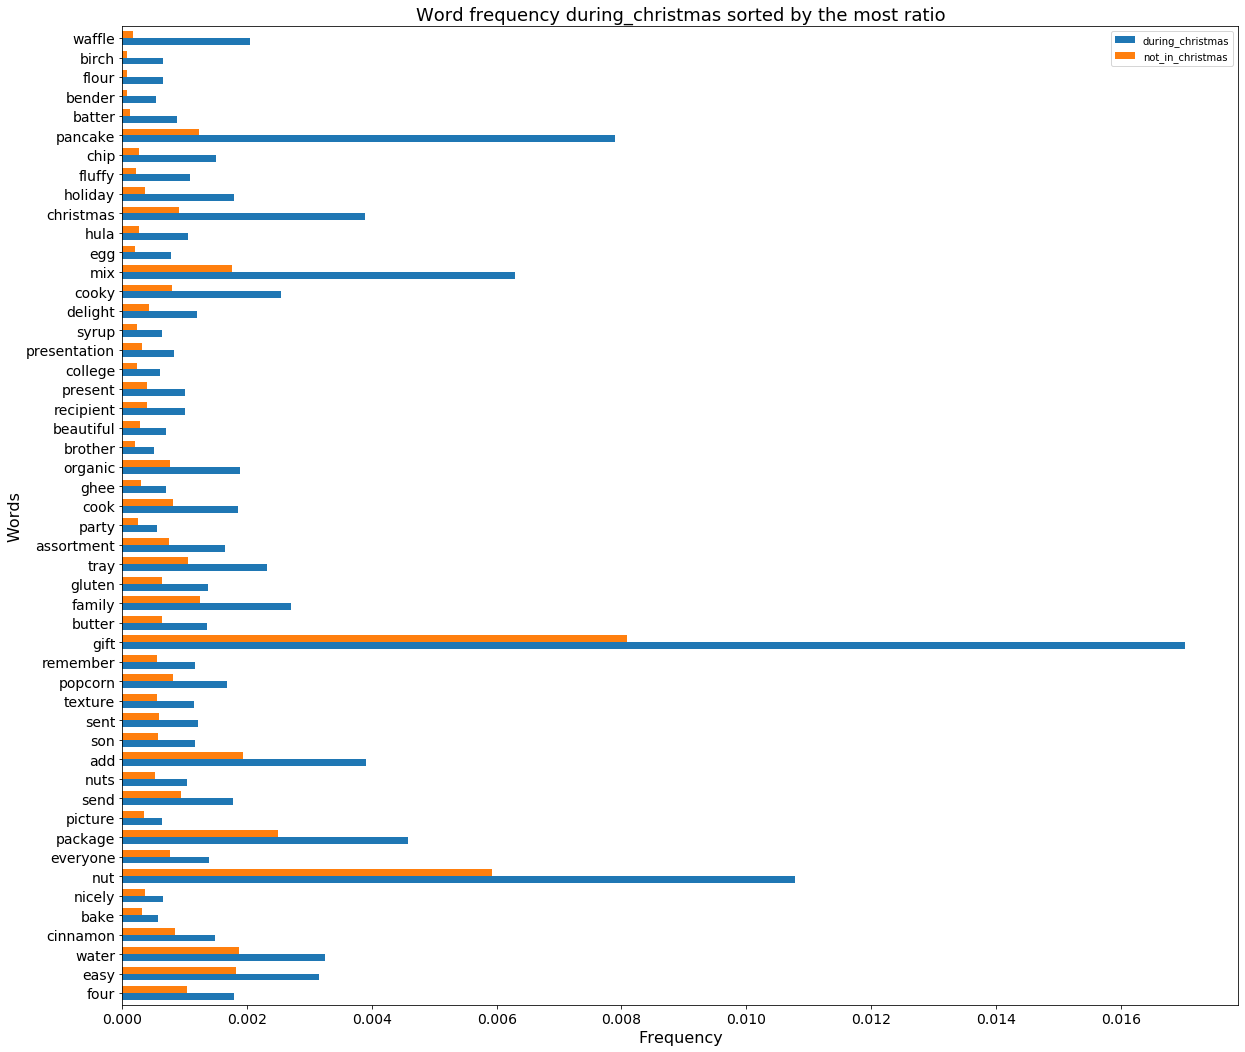

In [155]:
ax = freq_and_ratio.head(NUM_TOP_WORDS).sort_values(by='ratio')[columns_christmas].plot.barh(rot=0, figsize=(20,18), width=0.7)
ax.set_ylabel('Words', fontsize=16)
ax.set_xlabel('Frequency', fontsize=16)
ax.tick_params(labelsize=14)
_ = ax.set_title(f'Word frequency {columns_christmas[0]} sorted by the most ratio', fontsize=18)

Taking the ratio between the frequencies bring conclusive results. The goal was to take a period during the year and try to see if a particular event influences the former. Here, we take the month a december and try to show how Christmas is present during it. We can try to manually extract topics from the plot:

- Christmas : "Christmas", "Holiday", "Present", "Gift", "Package"

- Family : "Family", "Son", "Brother", "Everyone", "Party"

- Food, cooking and baking : "Waffle", "Flour", "Batter", "Pancakes", "Egg", "Mix", "Cook", "Cinnamon", "Butter", "Recipient"

The three main topics extracted here are all strongly related to Christmas. However, one should be careful about the conclusions regarding those topics since the one about cooking and baking is also related to winter. 

On top of that, we have to pay attention to the fact that we only consider words here and no n-gram. Indeed, among the top five sit the words "birch" and "bender". After a quick research, the first word seems to indicate a sort of wood and the second one a caracter from the famous show Futurama. Nevertheless, it is in fact a pancake/waffle mix.

<img src="https://naturamarket.ca/media/catalog/product/cache/af3e346b7c89cdcb7f0c99a9bb5c184f/b/i/birch-benders-paleo-pancake-mix.jpg" width="400px">

### Causal impact

In [22]:
from causalimpact import CausalImpact

In [23]:
def generate_weeks(year):
    acc_date = pd.datetime(year, 1, 1)
    weeks_df = pd.DataFrame({'week': [acc_date]}, columns=['week'])
    for i in range(0, NB_WEEKS):
        acc_date = acc_date + pd.Timedelta(f'7 days')
        temp_df = pd.DataFrame({'week': [acc_date]}, columns=['week'])
        weeks_df = pd.concat([weeks_df, temp_df])
    return weeks_df

In [24]:
def complete_missing_weeks(year, time_serie_df):
    #create series containing all weeks during the year
    all_weeks = generate_weeks(year)
    complete_time_serie_df = time_serie_df.merge(all_weeks, how='outer', left_on='reviewTime', right_on='week').sort_values(by='week')
    complete_time_serie_df = complete_time_serie_df.loc[:, complete_time_serie_df.columns != 'reviewTime']
    #fill in na values
    asin = time_serie_df.iloc[0,0]
    complete_time_serie_df['asin'] = complete_time_serie_df['asin'].fillna(asin)
    complete_time_serie_df['reviewCount'] = complete_time_serie_df['reviewCount'].fillna(0)
    return complete_time_serie_df.reset_index(drop=True)
    

In [25]:
def extract_non_event_products(reviews_weeks_df, nb_products_to_extract, year):
    # random sample nb_products_to_extract asins
    products_asin = reviews_weeks_df.asin.unique()
    nb_products = products_asin.shape[0]
    nb_products_to_extract = nb_products if nb_products < nb_products_to_extract else nb_products_to_extract
    indexes_to_extract = np.random.permutation(np.arange(0, nb_products))[:nb_products_to_extract]
    asins_to_extract = products_asin[indexes_to_extract]
    
    # iterate to create a dataframe with each column containing the time series of a product
    asins_time_series = pd.DataFrame()
    for a in asins_to_extract: 
        product = reviews_2017_weeks.loc[(reviews_2017_weeks.asin == a)]
        asins_time_series[a] = product['reviewCount']
    
    return asins_time_series

In [169]:
YEAR = 2017
NB_WEEKS = 51

In [227]:
years_and_weeks = pd.DataFrame(pd.date_range(start='2010-01-01', end="2018-05-01", freq='W'), columns=['reviewTime']).assign(merge=1)

In [228]:
asins = pd.DataFrame(reviews_per_week['asin'].unique(), columns=['asin']).assign(merge=1)

In [235]:
all_asins_and_weeks = years_and_weeks.merge(asins, on='merge')\
                                     .merge(reviews_per_week, on=['asin', 'reviewTime'], how='left')\
                                     .drop(columns=['merge'])

In [236]:
all_asins_and_weeks['reviewCount'] = all_asins_and_weeks['reviewCount'].fillna(0)
all_asins_and_weeks

,reviewTime,asin,reviewCount
0,2010-01-03,B00006BN4U,0.0
1,2010-01-03,B00008RCN8,0.0
2,2010-01-03,B0000CFH7B,0.0
3,2010-01-03,B0000CFMU7,0.0
4,2010-01-03,B0000CFPI2,0.0
...,...,...,...
1492045,2018-04-29,B01HH79XRE,19.0
1492046,2018-04-29,B01HH9IN64,12.0
1492047,2018-04-29,B01HJ4FWGG,2.0
1492048,2018-04-29,B01HJ7QPKU,0.0


In [237]:
christmas_activity = extract_activity_for_event(all_asins_and_weeks, CHRISTMAS_DATE, CHRISTMAS_DURATION, 10)

Filter reviews to only keep 2017 and products that have a minimum activity

In [238]:
reviews_2017_weeks = all_asins_and_weeks.loc[(all_asins_and_weeks['reviewTime'].dt.year == 2017)]

In [239]:
christmas_asins = christmas_activity['asin'].unique()

In [240]:
reviews_2017_weeks_nc = reviews_2017_weeks.loc[~reviews_2017_weeks.asin.isin(christmas_asins)]
reviews_2017_median = reviews_2017_weeks_nc.groupby(['asin'])['reviewCount'].median()
asins_filtered = reviews_2017_median[reviews_2017_median > 2].index.to_numpy()
reviews_2017_filtered = reviews_2017_weeks_nc[reviews_2017_weeks.asin.isin(asins_filtered)]
reviews_2017_filtered

/home/flo/EPFL/.venv-3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


,reviewTime,asin,reviewCount
1251954,2017-01-01,B0000CFPI2,8.0
1251964,2017-01-01,B0000DID5X,3.0
1251968,2017-01-01,B00014JNI0,3.0
1251969,2017-01-01,B000168QTU,17.0
1251972,2017-01-01,B00017028M,7.0
...,...,...,...
1433695,2017-12-31,B01GIUA4P6,0.0
1433699,2017-12-31,B01GOO6HRK,2.0
1433706,2017-12-31,B01GQ5WNC0,1.0
1433725,2017-12-31,B01H6IQING,2.0


Extract non christmas products

In [271]:
non_christmas_products = extract_non_event_products(reviews_2017_filtered, 200, 2017)

Get most active product in christmas

In [273]:
most_active_christmas = christmas_activity.loc[christmas_activity.event_start_date.dt.year == 2017].sort_values(by='delta', ascending=False)

In [274]:
most_active_christmas

,asin,median in year,mean in period,delta,event_start_date
1306,B006VXU6ZO,0.0,42.25,42.25,2017-12-01
2348,B00NY3LRHK,6.0,46.25,40.25,2017-12-01
2347,B00NY3LPGI,6.0,46.25,40.25,2017-12-01
1429,B0093J41PE,3.0,34.00,31.00,2017-12-01
3277,B01E9D0OR2,19.0,48.75,29.75,2017-12-01
2721,B00ZEA5ESY,0.0,29.00,29.00,2017-12-01
2962,B0179XFQ5E,0.0,27.50,27.50,2017-12-01
1997,B00I6R0KLS,0.0,25.25,25.25,2017-12-01
1831,B00FL6PCF6,0.0,22.50,22.50,2017-12-01
2765,B01136INBW,3.0,21.25,18.25,2017-12-01


In [275]:
active_prod_christmas = most_active_christmas.iloc[0,0]
active_prod_christmas

'B006VXU6ZO'

In [276]:
most_active_christmas_ts = reviews_2017_weeks.loc[(reviews_2017_weeks.asin == active_prod_christmas)]

In [277]:
most_active_christmas_ts = complete_missing_weeks(YEAR, most_active_christmas_ts)

In [278]:
c_product = most_active_christmas_ts['reviewCount'].to_numpy()

In [279]:
c_product

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0., 28., 27., 44., 43., 43., 39.,
       26.])

Append christmas product to whole dataframe

In [280]:
non_christmas_products['christmas_product'] = c_product

In [281]:
products_df = non_christmas_products[non_christmas_products.columns[::-1]]

Measure causal impact

In [282]:
pre_period = [0, 47]
post_period = [48, 52]

/home/flo/EPFL/.venv-3.7.0/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


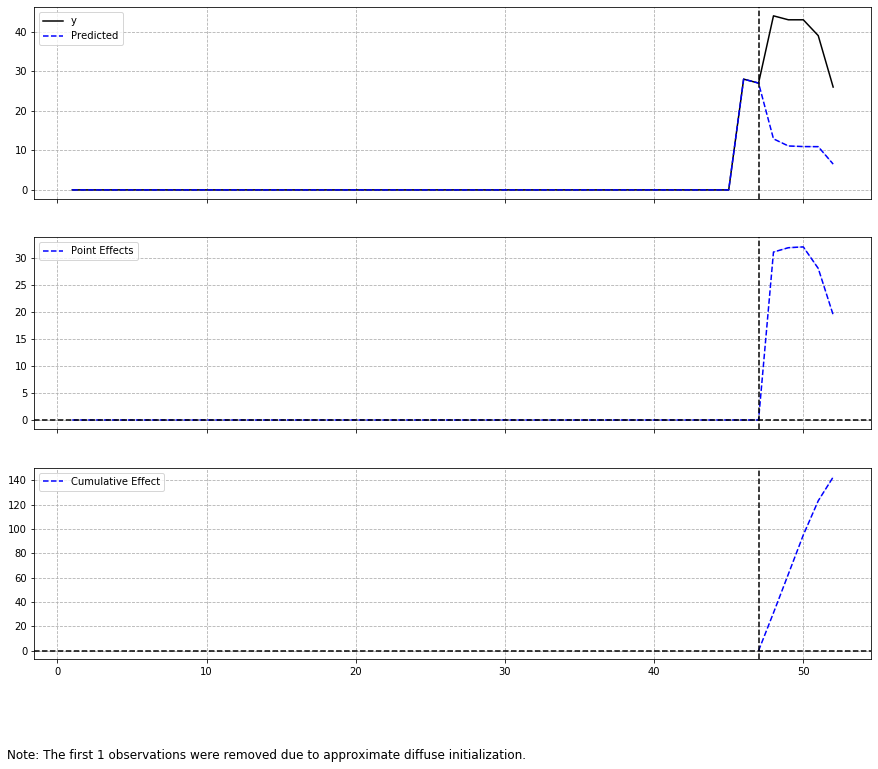

In [284]:
ci = CausalImpact(products_df[products_df.columns[:]], pre_period, post_period)
ci.plot()

In [286]:
ci.trained_model.params

sigma2.irregular    4.701542e-11
sigma2.level        6.944444e-05
beta.B005YVU6FY     2.032426e-02
beta.B001M1V5P0     5.063404e-03
beta.B00KRFLDBS     1.360938e-02
                        ...     
beta.B0096RWIPS     6.370637e-02
beta.B004CMAQGK    -4.209007e-02
beta.B004NRLAVY    -8.163115e-02
beta.B002863BIW     2.293839e-02
beta.B01EAG3VZA    -2.766168e-02
Length: 202, dtype: float64

In [270]:
print(ci.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    39.0               195.0
Prediction (s.d.)         -11.5 (0.26)       -57.48 (1.31)
95% CI                    [-11.97, -10.95]   [-59.87, -54.73]

Absolute effect (s.d.)    50.5 (0.26)        252.48 (1.31)
95% CI                    [49.95, 50.97]     [249.73, 254.87]

Relative effect (s.d.)    -439.23% (2.28%)   -439.23% (2.28%)
95% CI                    [-443.38%, -434.44%][-443.38%, -434.44%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


### Word embeddings for trend analysis

All this is promising but our research axes are both to find impact of events, periodic or not, in the dataset and of trends. Our first case study was to find and measure the impact of vegetarianism/veganism in the data. What we presented until now is not useful for extracting such an information, it permits to measure punctual effect but not effect over multiple years. That's why the second approach is essential, we can use word embeddings to measure the document similarity between a trend and reviews or products. This way we can see how a trend evolves over the years.

For that we use gensim's [word2vec](https://radimrehurek.com/gensim/models/word2vec.html) library, with google's pre-trained model.

In [22]:
from gensim.models import Word2Vec, KeyedVectors

# reference of model: https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing
# Taken from https://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/
google_model = KeyedVectors.load_word2vec_format('./data/GoogleNews-vectors-negative300.bin', binary=True)

We compare the beginning of the dataset (2003 to 2010) and one month of 2017 so to have around the same number of reviews

In [24]:
before_start = pd.datetime(2003,1,1)
before_end = pd.datetime(2010,1,1)
after_start = pd.datetime(2017,6,1)
after_end = pd.datetime(2017,7,1)

In [23]:
healthy_words = ['fitness', 'calorie', 'weight', 'health', 'vitamin', 'diet', 'supplement', 'nutrition', 'balance', 'vegetable', 'veggie', 'salad']

In [42]:
def compare_review(model, review_texts, word_set):
    similarities = []
    for review_text in review_texts:
        valid_text = [word for word in review_text if word in model.vocab]
        if len(valid_text) == 0:
            continue
        similarities.append((' '.join(valid_text), model.n_similarity(valid_text, word_set)))
        
    return similarities

We lemmatize the review texts as it makes more sense to compare documents with only meaningful words in it. Additionnally, we remove the reviews that have less than 10 characters. This is a bit arbitrary for the moment but this is because we expect those reviews to not have meaningful informations.

In [34]:
reviews_before = reviews.loc[(before_start < reviews.reviewTime) & (reviews.reviewTime < before_end)]
reviews_before = reviews_before.loc[reviews_before['reviewText'].str.len() > 10, 'reviewText']
reviews_before = reviews_before.apply(lemmatize).to_numpy()

reviews_after = reviews.loc[(after_start < reviews.reviewTime) & (reviews.reviewTime < after_end)]
reviews_after = reviews_after.loc[reviews_after['reviewText'].str.len() > 10, 'reviewText']
reviews_after = reviews_after.apply(lemmatize).to_numpy()

In [36]:
print("Number of reviews before: ", reviews_before.shape[0])
print("Number of reviews before: ", reviews_after.shape[0])

Number of reviews before:  89155
Number of reviews before:  65612


In [43]:
similarities_before = compare_review(google_model, reviews_before, healthy_words)
similarities_after = compare_review(google_model, reviews_after, healthy_words)

The two arrays we just computed contain the similarities between the set representing the healty food and the reviews. To extract meaningful informations, we can compare the similarity factors between the reviews that match the most. We do it that way because the way we compare this similarity is biased. Indeed, we compare it using word2vec with google's pre-trained model. This model is trained on google news, thus in those documents any document that speaks about food will have some similarity with our set. In other words, given the amount of information and the number of different topics in google news the model will probably give the same cosine similarity between 'healthy' and 'fat' and 'healthy' and 'vegetables'. The best would be to have a word2vec model trained on food documents, to be able to differ between different categories of food. Also the reviews that matches the most are the most interesting.

In [60]:
print("From 2003 to 2010")
similarities_before = sorted(similarities_before, key=lambda x: x[1])
for text, sim in similarities_before[-5:][::-1]:
    print("With similarity %.2f: \n\"%s\"" % (sim, text))
    
print("\n\nIn 2017")
similarities_after = sorted(similarities_after, key=lambda x: x[1])
for text, sim in similarities_after[-5:][::-1]:
    print("With similarity %.2f: \n\"%s\"" % (sim, text))
#np.mean(sorted(mean_sim_2000)[-1000:])

From 2003 to 2010
With similarity 0.82: 
"really good munchies nutritional info site nutrition facts serve size oz approx serving pound amount per serve calorie calorie fat daily value total fat 6g saturate fat 1g cholesterol 0mg sodium total carbohydrate dietary fiber 3g sugar 5g protein 1g vitamin calcium vitamin iron contains less percent daily value nutrient percent daily value base calorie diet ingredient sweet potato squash carrot green bean taro non hydrogenate canola oil dextrin salt"
With similarity 0.81: 
"organic fruit snack naturally fat free cholesterol free low sodium really place call stretch island really town call organic fruit leather make usda organic certify organic washington state department agriculture accordance organic standard u department agriculture diabetic diet exchange fruit fact nutrition fact serve size bar serving per container amount per serve calorie total fat daily value total fat saturate fat cholesterol mg sodium mg potassium mg total carbohydrate

As we can see results are not conclusive in this approach for now. However as we can see in the reviews, the word2vec model works very well but this techinque is not well handled yet. What would be better to measure the similarity factor of a review would be to measure the similarity between the set and each word and to focus only on words that matches the most. Here it is likely that the words in a given review that are really similar to the healthy topic are drown by all the other words. On the other hand, another approach would be to grow a bigger pool of words about the healthy topic and make string equalities between the set and the reviews in order to see what reviews matches the most words, but it would be computationally too expensive.

## Training of Word2Vec on meta title and description

Lemmatize every title and description

In [28]:
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=4, progress_bar=True)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [32]:
meta['description'] = meta['description'].parallel_apply(lemmatize)
meta['title'] = meta['title'].parallel_apply(lemmatize)

In [34]:
meta.to_csv('data/meta_lemm')

In [158]:
meta = pd.read_csv('data/meta_lemm.csv')

Replace na str with empty string and delete garbage from javascript error from scraping

In [159]:
meta['title'] = meta['title'].fillna('')
meta['description'] = meta['description'].fillna('')

In [160]:
meta.loc[meta['title'].str.contains('apagestart|var')] = ' '

Word count to see if there's any garbage we want to delete (commons words)

In [161]:
meta['title_and_desc'] = pd.DataFrame(meta['description'] + ' ' + meta['title'], columns=['title_and_desc']).dropna().astype({'title_and_desc': 'str'})
meta['title_and_desc'] = pd.DataFrame(meta['title_and_desc'].apply(lambda s : str(s).split()))
words = meta.explode('title_and_desc')

In [162]:
words = pd.DataFrame(words['title_and_desc'].value_counts())

In [165]:
words[:50]

,title_and_desc
pack,115885
flavor,109002
oz,107549
tea,88134
ounce,79013
make,75526
organic,70348
chocolate,68629
coffee,65084
sugar,60859


In [171]:
sentences = meta['title_and_desc'].to_numpy()

In [169]:
import gensim.models

In [208]:
model = gensim.models.Word2Vec(sentences=sentences, workers=4, min_count=10)

In [211]:
model.most_similar('italy')

/home/flo/EPFL/.venv-3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('campania', 0.6908035278320312),
 ('greece', 0.6781868934631348),
 ('naples', 0.6767177581787109),
 ('tuscany', 0.6587968468666077),
 ('veneto', 0.6473205089569092),
 ('parma', 0.641181230545044),
 ('spain', 0.6410231590270996),
 ('sicily', 0.6375719308853149),
 ('emilia', 0.635952889919281),
 ('lazio', 0.6327407956123352)]

In [220]:
model.similarity('vegan', 'tofu')

/home/flo/EPFL/.venv-3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.31936315